In [258]:
import sys
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

plt.style.use('ggplot') 
%matplotlib inline

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis. The query was exported from Porticoto the file ADMISSIONS_ICUSTAY_SEPSIS.csv. The data was read into a pandas dataframe lab_events 


In [259]:
data = pd.DataFrame.from_csv('SEPSIS_CHARTEVENTS_FIRST24.csv')
data.head()

,itemid,valuenum,subject_id,infection,explicit_sepsis,organ_dysfunction,mech_vent,angus,label
icustay_id,,,,,,,,,
267691,52,64.0,14478,1,0,1,0,1,Arterial BP Mean
267691,113,4.0,14478,1,0,1,0,1,CVP
267360,52,73.0,14511,1,0,1,1,1,Arterial BP Mean
267360,52,67.0,14511,1,0,1,1,1,Arterial BP Mean
249119,52,69.0,14515,1,0,1,1,1,Arterial BP Mean


## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [54]:
data['subject_id'] = data.index
data.set_index(np.arange(data.shape[0]), inplace = True)
cols = list(data.columns)
cols.insert(0, cols.pop(cols.index('subject_id')))
data = data[cols]

In [62]:
data2 = data.drop_duplicates('subject_id', keep = 'first') 
data2.shape

(1632, 13)

In [184]:
data[data.label.str.contains('White')].label.unique()

array([], dtype=object)

In [173]:
#data[data.label.str.contains('Heart Rate')].label.unique()
data[data.label == 'Heart Rhythm'].label.count()

114025

In [137]:
labels = list(data.label.unique())

In [138]:
labels.sort()
ord(labels[100][0]) < ord('B')

True

In [162]:
labels2 = [word for word in labels if ((ord(word[0]) < ord('N')) & (ord(word[0]) > ord('L')))]
labels2.sort()
display(labels2)                                                                  
                                                                  


['MAMMARY SUPPORT',
 'MDI #1 Drug',
 'MDI #1 Puff',
 'MDI #1 [Drug]',
 'MDI #1 [Puff]',
 'MDI #2 Drug',
 'MDI #2 Puff',
 'MDI #2 [Drug]',
 'MDI #2 [Puff]',
 'MDI #3 Drug',
 'MDI #3 Puff',
 'MDI #3 [Drug]',
 'MDI #3 [Puff]',
 'Magnesium',
 'Magnesium (1.6-2.6)',
 'Manual BP Mean(calc)',
 'Manual BP [Diastolic]',
 'Manual BP [Systolic]',
 'Manual Blood Pressure Diastolic Left',
 'Manual Blood Pressure Diastolic Right',
 'Manual Blood Pressure Systolic Left',
 'Manual Blood Pressure Systolic Right',
 'MapApacheIIScore',
 'MapApacheIIValue',
 'Marital Status',
 'Mean Airway Pressure',
 'Mean PAW [Meas]',
 'Mech. Minute Volume',
 'Med Wasted [Amount]',
 'Med Wasted [Drug]',
 'Medication Added #1 (Peritoneal Dialysis)',
 'Medication Added #2 (Peritoneal Dialysis)',
 'Medication Added Amount  #1 (Peritoneal Dialysis)',
 'Medication Added Amount  #2 (Peritoneal Dialysis)',
 'Medication Added Units #1 (Peritoneal Dialysis)',
 'Medication Added Units #2 (Peritoneal Dialysis)',
 'Medication Bolus

In [94]:
data[data.label.str.contains('cvp')].label.unique()

array([], dtype=object)

In [213]:
data_CO = pd.DataFrame(data[(data.label == 'C.O.(thermodilution)') | 
               (data.label == 'Cardiac Output (thermodilution)')].groupby('subject_id')['valuenum'].max())
data_CO.columns = ['CO_max']

In [218]:
WBC_df = pd.DataFrame(data[data.label == 'WBC'].groupby('subject_id')['valuenum'].mean())
WBC_df.columns = ['WBC_mean']
RR_df = pd.DataFrame(data[data.label == 'Respiratory Rate'].groupby('subject_id')['valuenum'].mean())
RR_df.columns = ['RR_mean']
MAP_df = pd.DataFrame(data[(data.label == 'ART BP mean') | 
                (data.label == 'Arterial BP Mean')].groupby('subject_id')['valuenum'].mean())
MAP_df.columns = ['MAP_mean']
HR2_df = pd.DataFrame(data[data.label == 'Heart Rhythm'].groupby('subject_id')['valuenum'].mean())
HR2_df.columns = ['HR2_mean']
HR_df = pd.DataFrame(data[data.label == 'Heart Rate'].groupby('subject_id')['valuenum'].mean())
HR_df.columns = ['HR_mean']
CVP_med_df = pd.DataFrame(data[data.label == 'CVP'].groupby('subject_id')['valuenum'].median())
CVP_med_df.columns = ['CVP_med']
CVP_min_df = pd.DataFrame(data[data.label == 'CVP'].groupby('subject_id')['valuenum'].min())
CVP_min_df.columns = ['CVP_min']
pH_df = pd.DataFrame(data[(data.label == 'Arterial pH') | (data.label == 'PH (Arterial)') | 
              (data.label == 'Art.pH') ].groupby('subject_id')['valuenum'].min())
pH_df.columns = ['pH_min']
LAC_mean_df = pd.DataFrame(data[(data.label == 'Lactic Acid')].groupby('subject_id')['valuenum'].mean())
LAC_mean_df.columns = ['LAC_mean']
LAC_min_df = pd.DataFrame(data[(data.label == 'Lactic Acid')].groupby('subject_id')['valuenum'].min())
LAC_min_df.columns = ['LAC_min']

In [225]:
data3 = data2.copy()
data3.set_index(['subject_id'], inplace = True)

In [226]:
data3 = data3.merge(CO_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(WBC_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(RR_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(MAP_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(HR_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(HR2_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(CVP_med_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(CVP_min_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(pH_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(LAC_mean_df, left_index = True, right_index = True, how='left', sort = True)
data3 = data3.merge(LAC_min_df, left_index = True, right_index = True, how='left', sort = True)

In [227]:
data3.head()

,gender,expire_flag,admittime,diagnosis,intime,charttime,itemid,cgid,value,valuenum,...,WBC_mean,RR_mean,MAP_mean,HR_mean,HR2_mean,CVP_med,CVP_min,pH_min,LAC_mean,LAC_min
subject_id,,,,,,,,,,,,,,,,,,,,,
21,M,1,2135-01-30 20:50:00,SEPSIS,2134-09-11 20:50:04,2134-09-11 19:30:00,784,15331.0,555,555.0,...,28.600000,16.847458,82.222222,71.983333,NaN,18.0,13.0,7.20,2.166667,1.9
33,M,0,2116-12-23 22:30:00,SEPSIS;TELEMETRY,2116-12-23 22:31:53,2116-12-23 23:12:00,818,15331.0,6,6.0,...,26.500000,17.400000,NaN,66.800000,NaN,6.5,4.0,NaN,2.700000,1.0
38,M,0,2166-08-10 00:28:00,ACUTE MYOCARDIAL INFARCTION-SEPSIS,2166-08-10 00:29:36,2166-08-10 00:00:00,5820,17155.0,90,90.0,...,18.200000,24.441860,NaN,105.659091,NaN,9.0,1.0,NaN,2.800000,2.8
62,M,0,2113-02-15 00:19:00,"SEPSIS,URINARY TRACT INFECTION",2113-02-15 00:20:44,2113-02-15 01:00:00,5817,15023.0,80,80.0,...,11.775000,21.909091,NaN,55.840909,NaN,14.0,10.0,NaN,2.100000,1.4
94,M,1,2176-02-25 16:49:00,SEPSIS,2176-02-25 16:50:03,2176-02-25 17:30:00,1162,15331.0,8,8.0,...,8.033333,20.144578,61.695652,95.590361,NaN,3.0,0.0,7.29,1.333333,0.9


In [229]:
data3.drop(['admittime', 'intime', 'charttime', 'itemid', 'cgid', 'value', 
            'valuenum', 'valueuom', 'label'], axis = 1, inplace = True)

In [235]:
print "CO        {}".format(data_CO.shape)
print "WBC       {}".format(data_WBC.shape)
print "RR        {}".format(data_rr.shape)
print "MAP       {}".format(data_MAP.shape)
print "HR        {}".format(data_hr.shape)
print "HR2       {}".format(data_hr2.shape)
print "CVP_med   {}".format(data_CVP_med.shape)
print "CVP_min   {}".format(data_CVP_min.shape)
print "pH        {}".format(data_pH.shape)
print "Lac_mean  {}".format(data_Lac_mean.shape)
print "Lac_min   {}".format(data_Lac_min.shape)

CO        (133, 1)
WBC       (1448, 1)
RR        (1623, 1)
MAP       (694, 1)
HR        (1629, 1)
HR2       (1626, 1)
CVP_med   (696, 1)
CVP_min   (696, 1)
pH        (1099, 1)
Lac_mean  (1277, 1)
Lac_min   (1277, 1)


In [237]:
ptnt_demog = pd.DataFrame.from_csv('ADMISSIONS_ICUSTAY_SEPSIS_revised.csv')
ptnt_demog.head()

,gender,diagnosis,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,
21,M,SEPSIS,1,Medicare,MARRIED,WHITE,MICU,MICU,87.0,15.0,368.0
94,M,SEPSIS,0,Medicare,MARRIED,ASIAN,CCU,CCU,74.0,4.0,26.0
157,M,SEPSIS,0,Medicare,SINGLE,WHITE,MICU,MICU,80.0,6.0,98.0
166,F,SEPSIS,1,Medicare,WIDOWED,WHITE,MICU,CCU,NaN,0.0,6.0
188,M,SEPSIS,0,Private,MARRIED,WHITE,SICU,SICU,51.0,3.0,28.0


In [257]:
data3.diagnosis.unique()

array(['SEPSIS', 'SEPSIS;TELEMETRY', 'ACUTE MYOCARDIAL INFARCTION-SEPSIS',
       'SEPSIS,URINARY TRACT INFECTION', 'UROSEPSIS', 'NON Q MU;UROSEPSIS',
       'PNEUMONIA,SEPSIS', 'SEPSIS;PILONIDAL ABSCESS',
       'UROSEPSIS-CHANGE IN MENTAL STATUS', 'CELLULITIS;SEPSIS',
       'SEPSIS,STROKE', 'PNEUMONIA/SEPSIS/RAPID AFIB',
       'SEPSIS;LIVER FAILURE', 'FEVER/SEPSIS',
       'INFECTED STONE,ACUTE RENAL FAILURE,SEPSIS', 'ENDOCARDITIS/SEPSIS',
       'SEPSIS;THROMBOCYTOPENIA;MENTAL STATUS CHANGES',
       'MYOCARDIAL INFARCTION-SEPSIS',
       'SEPSIS;LIVER FAILURE;SHORT GUT SYNDROME',
       'SEPSIS;RESPIRATORY FAILURE;ACUTE RENAL FAILURE',
       'CHEST PAIN;SEPSIS', '? SEPSIS', 'CELLULITIS/SEPSIS',
       'SEPSIS;METHICILLIN RESISTANT STAPH AUREUS;VANCOMYCIN RESISTANT ENTEROCOCCUS',
       'RESPIRATORY DISTRESS,UROSEPSIS', 'SEPSIS/ AFIB',
       'SEPSIS;LEFT FOOT ULCER', 'MENTAL STATUS CHANGES;R/O SEPSIS',
       'SEPSIS; BLADDER CANCER', 'SEPSIS;WEAKNESS',
       'SEPSIS;MYOCARDIAL

In [239]:
data4 = data3[data3.diagnosis == 'SEPSIS'].copy()
data4 = data4.merge(ptnt_demog, left_index = True, right_index = True, how='left', sort = True)
data4.head()

,gender_x,expire_flag,diagnosis_x,CO_max,WBC_mean,RR_mean,MAP_mean,HR_mean,HR2_mean,CVP_med,...,diagnosis_y,hospital_expire_flag,insurance,marital_status,ethnicity,first_careunit,last_careunit,age,adm_stay_days,icu_stay_hours
subject_id,,,,,,,,,,,,,,,,,,,,,
21,M,1,SEPSIS,NaN,28.600000,16.847458,82.222222,71.983333,NaN,18.0,...,SEPSIS,1.0,Medicare,MARRIED,WHITE,MICU,MICU,87.0,15.0,368.0
94,M,1,SEPSIS,NaN,8.033333,20.144578,61.695652,95.590361,NaN,3.0,...,SEPSIS,0.0,Medicare,MARRIED,ASIAN,CCU,CCU,74.0,4.0,26.0
157,M,1,SEPSIS,NaN,47.375000,21.468750,75.258065,81.781250,NaN,9.5,...,SEPSIS,0.0,Medicare,SINGLE,WHITE,MICU,MICU,80.0,6.0,98.0
166,F,1,SEPSIS,NaN,NaN,35.600000,NaN,85.800000,NaN,NaN,...,SEPSIS,1.0,Medicare,WIDOWED,WHITE,MICU,CCU,NaN,0.0,6.0
188,M,1,SEPSIS,16.700001,7.992000,16.099138,99.263889,75.973799,NaN,11.0,...,SEPSIS,0.0,Private,MARRIED,WHITE,SICU,SICU,51.0,3.0,28.0


In [255]:
data4.isnull().sum()
data5 = data4.drop(['CO_max', 'HR2_mean'], axis = 1)

In [247]:
display(data4[data4.hospital_expire_flag == 1].dropna().shape)
display(data4[data4.hospital_expire_flag == 0].dropna().shape)

(0, 25)

(0, 25)

In [256]:
data5.shape

(1262, 23)

In [45]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}
'''
# a list is created containing units of measure for the lab measurements
lab_units = ['g/dL',
        'mEq/L',
        'mEq/L',
        'mg/dL',
        '',
        'mEq/L',
        'mg/dL',
        'mg/dL',
        '%', 
        'g/dL',
        '',
        'mmol/L',
        'mmol/L',
        'mg/dL',
        'K/uL',
        'mEq/L',
        '',
        'sec',
        'mmol/L',
        '']

# currently using lab_measures and lab_units to create the dict. 
# could be done more succinctly using the dictionary described above
labs_dict = dict(zip(lab_measures, lab_units))
print labs_dict


{'wbc_1st': '', 'bicarbonate_1st': 'mEq/L', 'phosphate_1st': 'mg/dL', 'hematocrit_1st': '%', 'chloride_1st': 'mEq/L', 'lactate_1st': 'mmol/L', 'potassium_1st': 'mEq/L', 'glucose_1st': 'mg/dL', 'creatinine_1st': 'mg/dL', 'magnesium_1st': 'mmol/L', 'aniongap_1st': 'mEq/L', 'pt_1st': '', 'hemoglobin_1st': 'g/dL', 'ptt_1st': 'sec', 'albumin_1st': 'g/dL', 'bun_1st': '', 'inr_1st': '', 'bilirubin_1st': 'mg/dL', 'sodium_1st': 'mmol/L', 'platelet_1st': 'K/uL'}


## Plotting frequency distribution for each lab measurement for both survival and non-survival groups. 

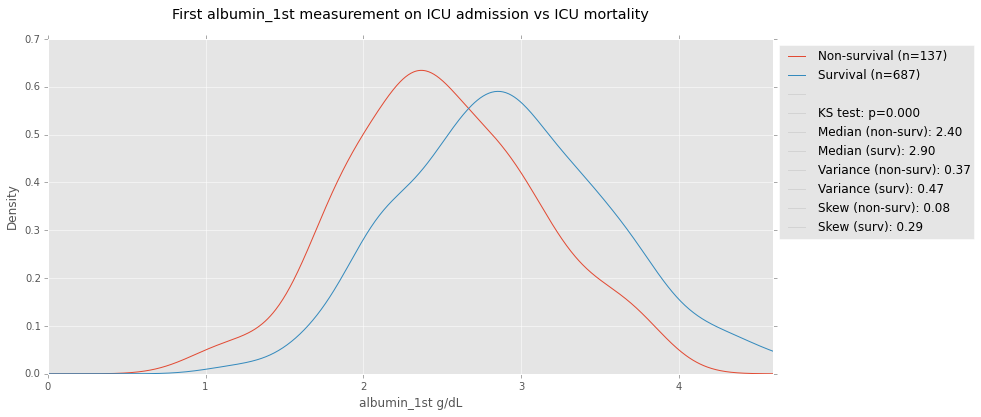

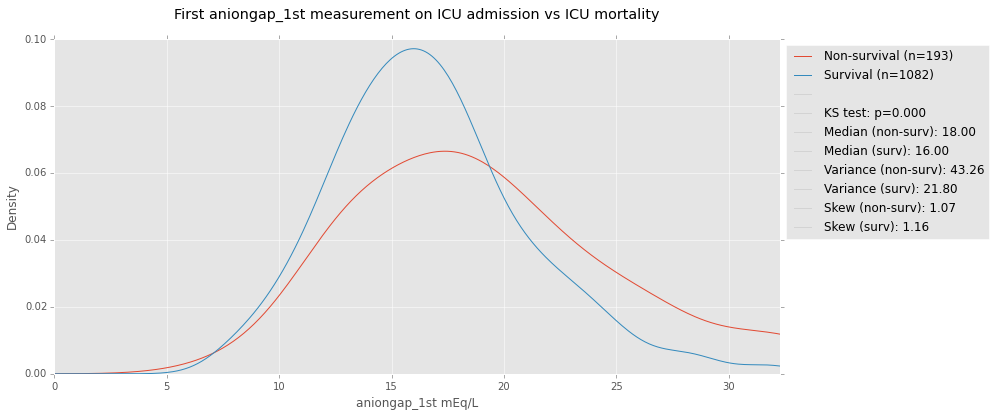

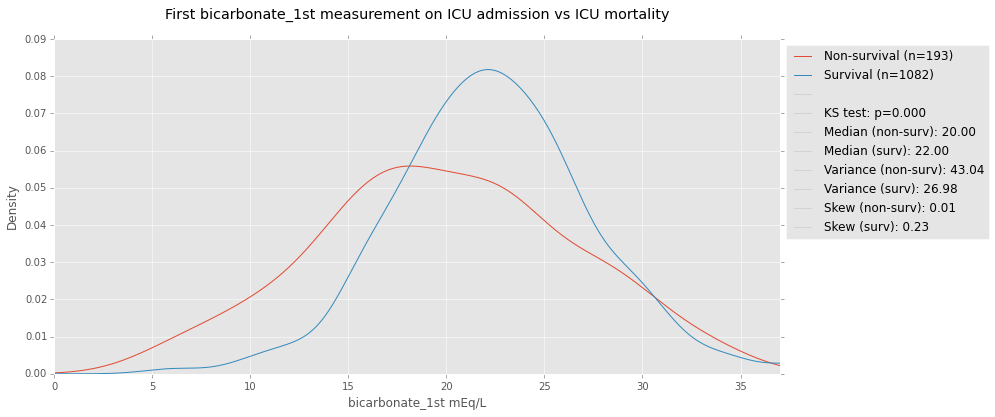

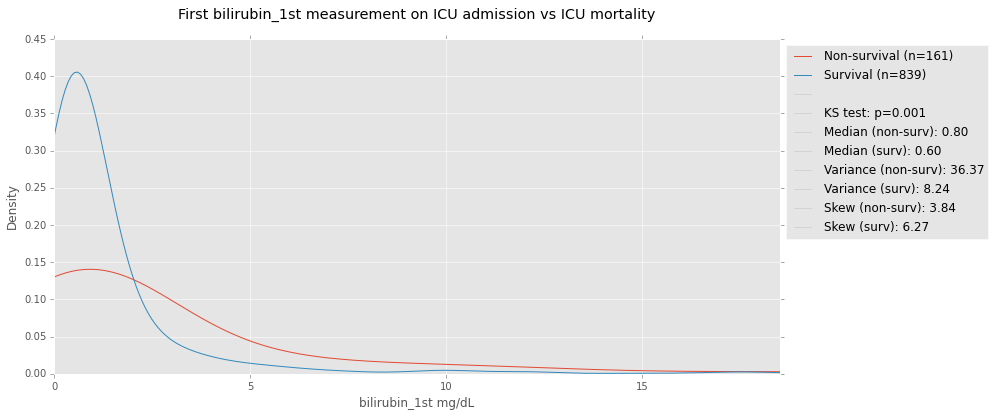

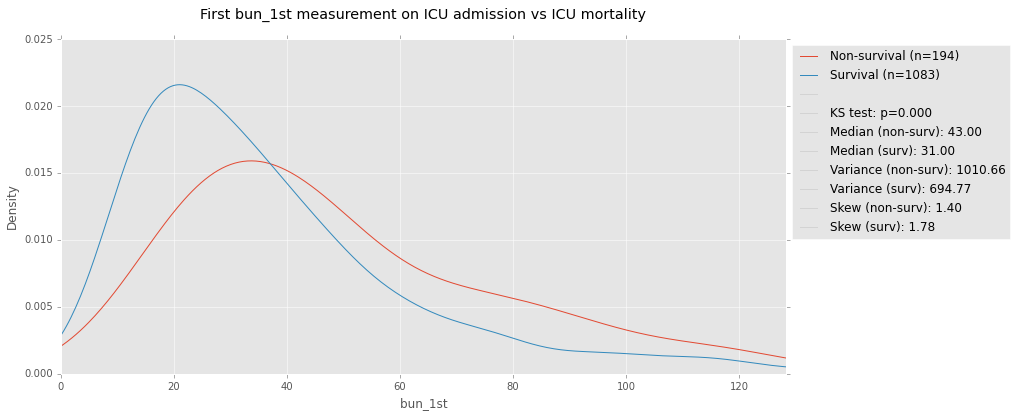

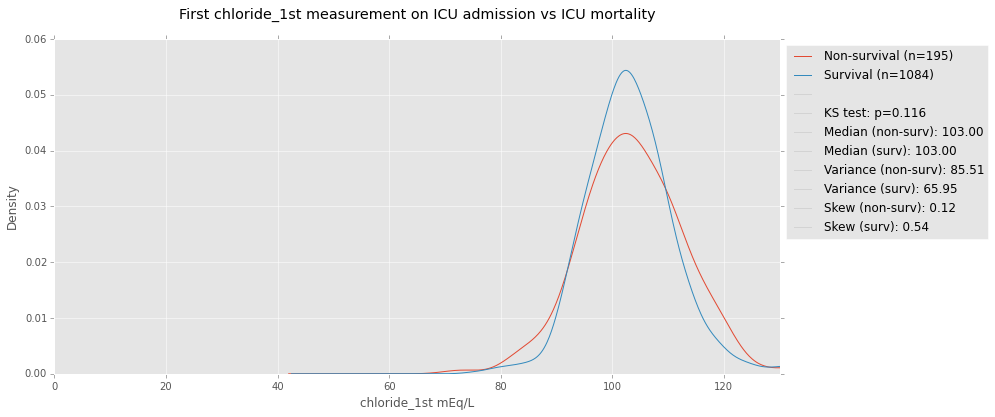

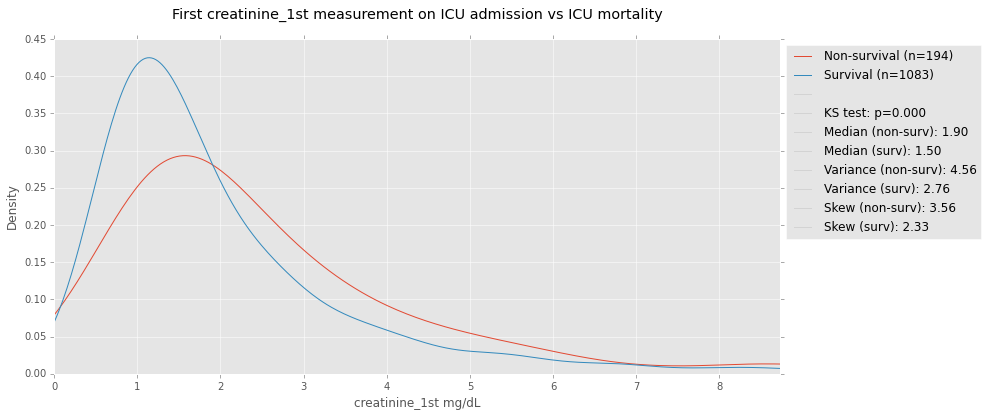

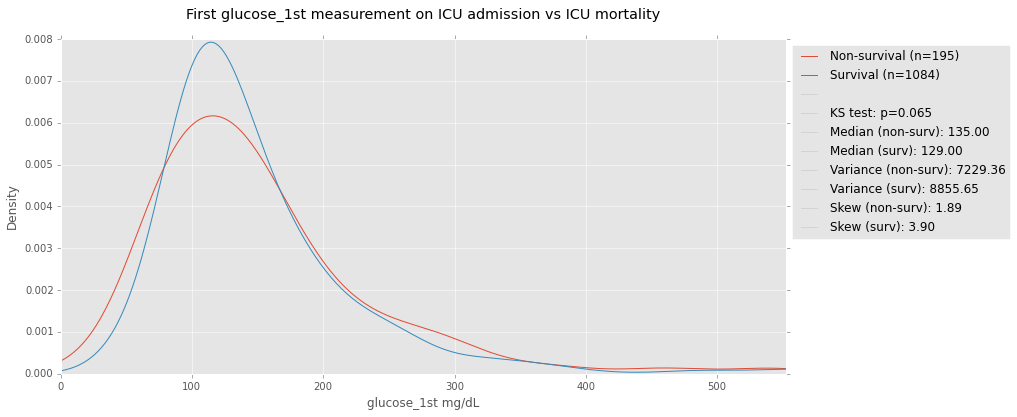

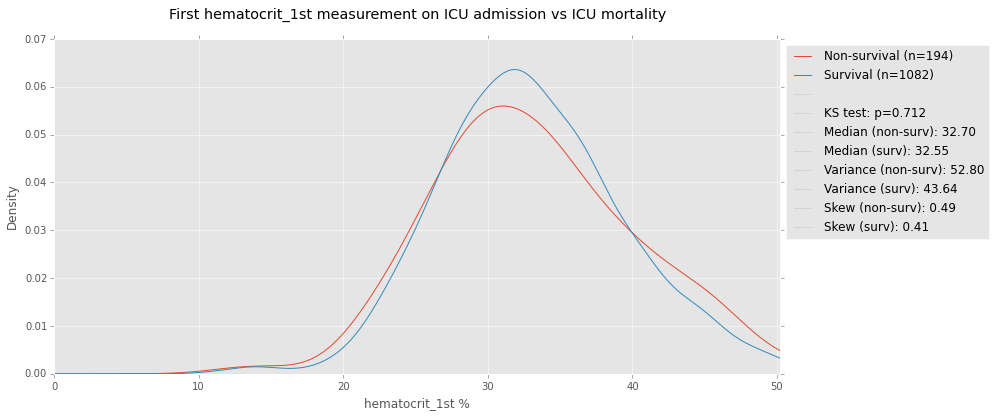

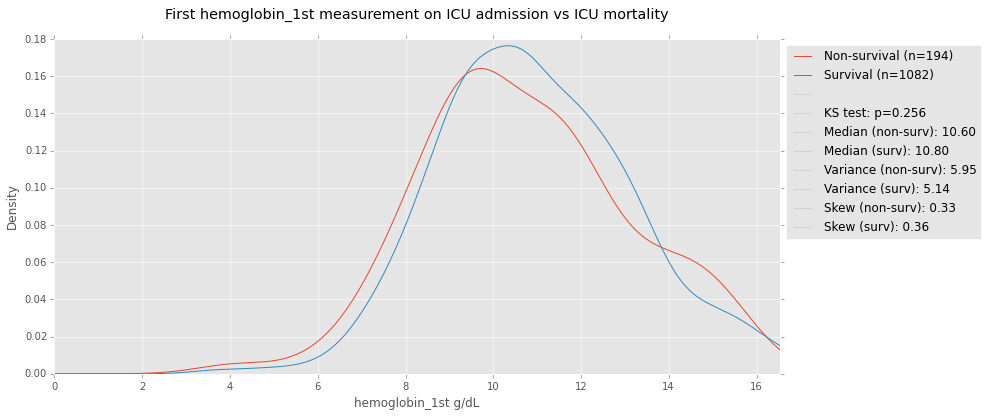

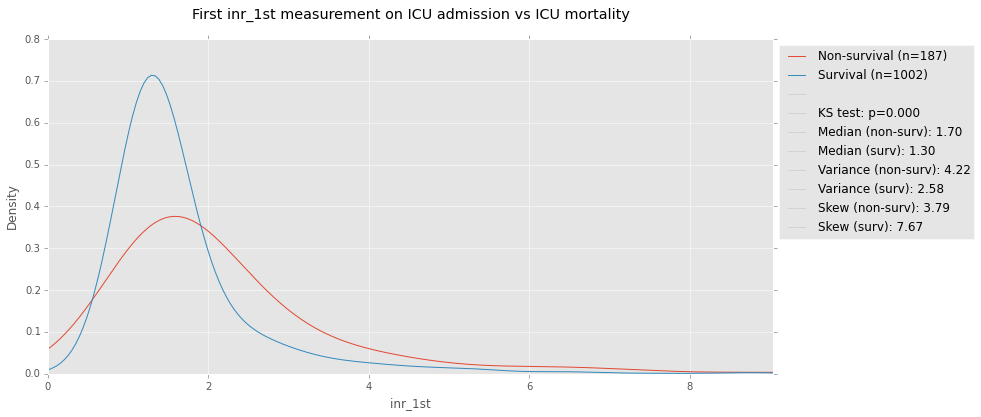

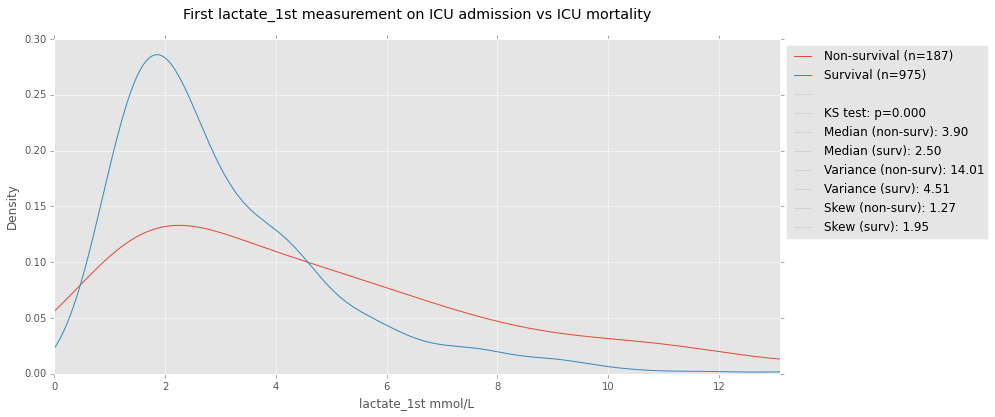

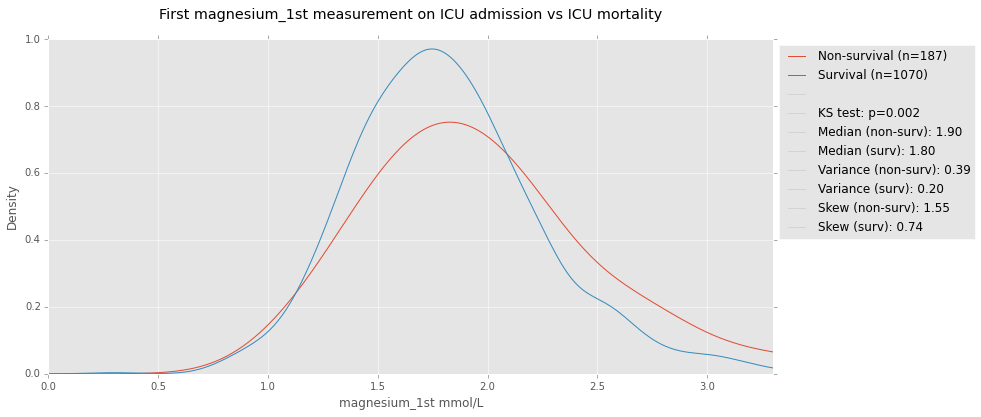

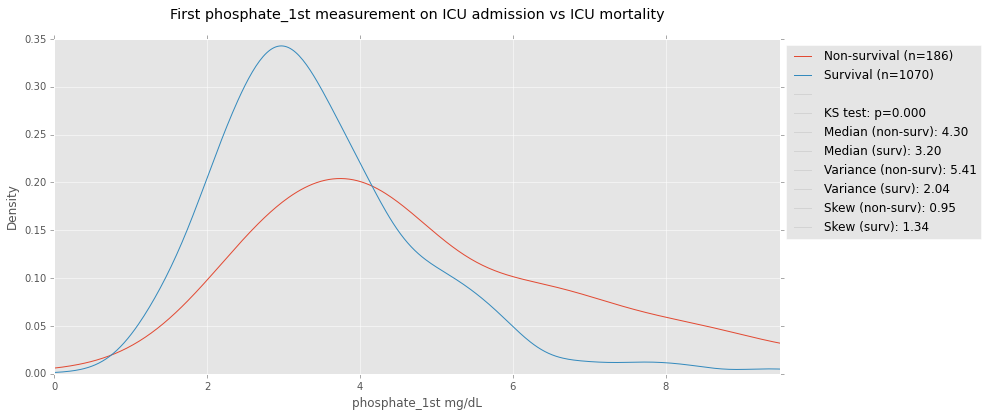

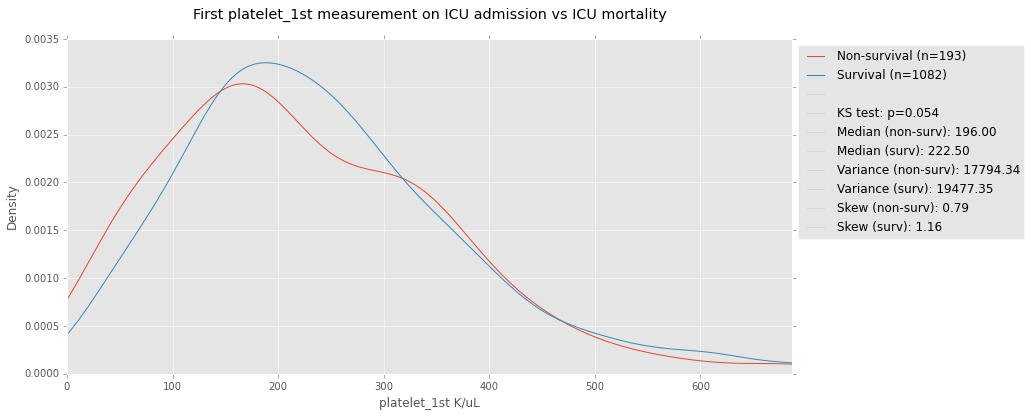

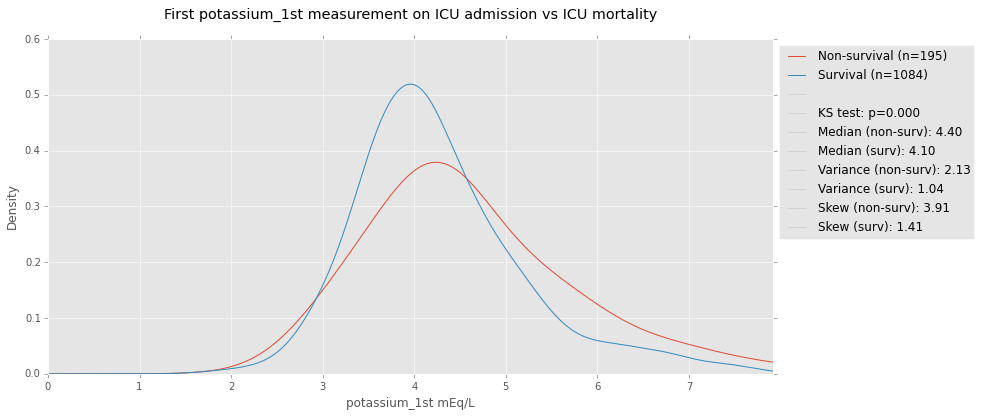

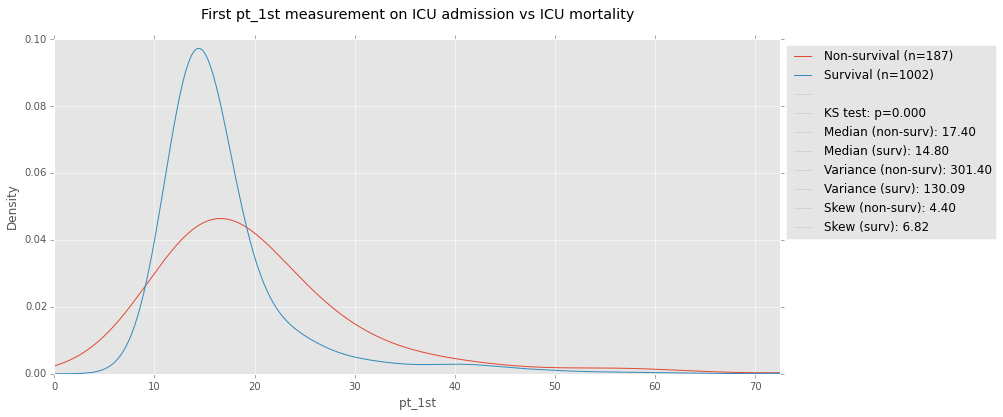

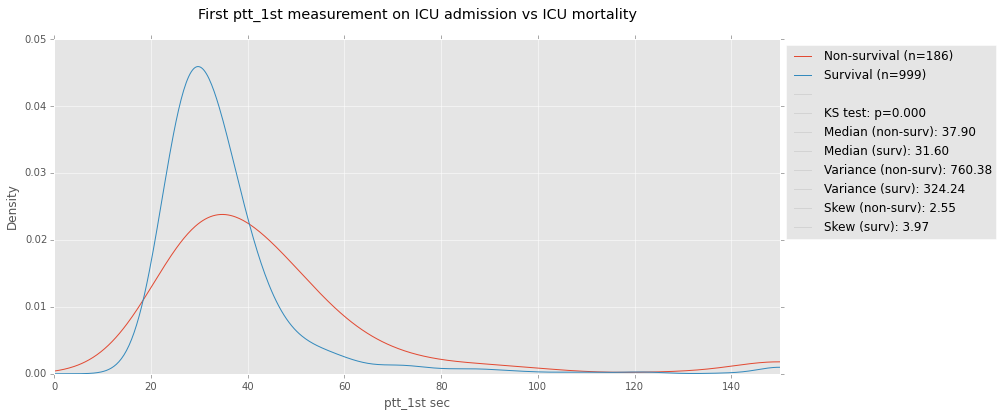

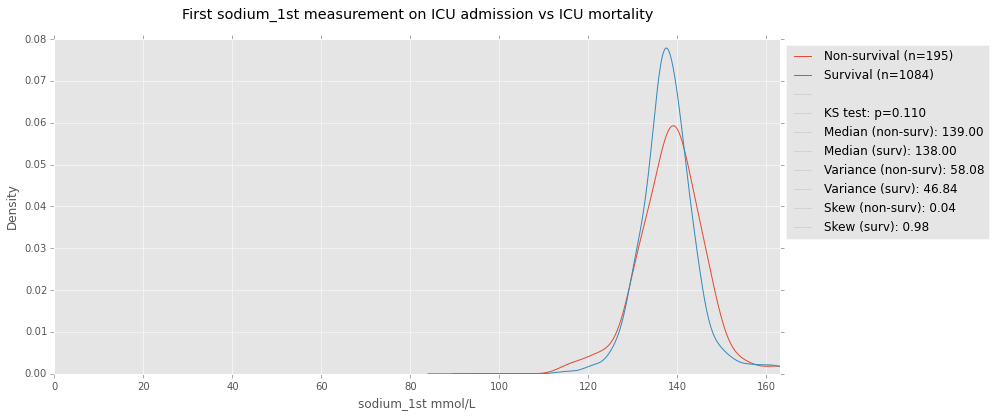

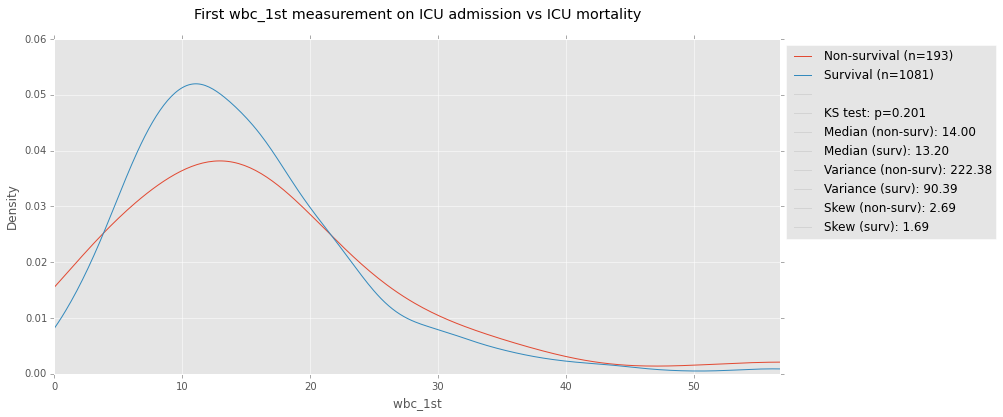

In [46]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = data[l][data.mort_icu==1].dropna().count()
    n_surv = data[l][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l][data.mort_icu==1].dropna().median()
    med_surv = data[l][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l][data.mort_icu==1].dropna().var()
    var_surv = data[l][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l][data.mort_icu==1].dropna().skew()
    skew_surv = data[l][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Generating box-plots for each variable for both survival and non-survival groups. 

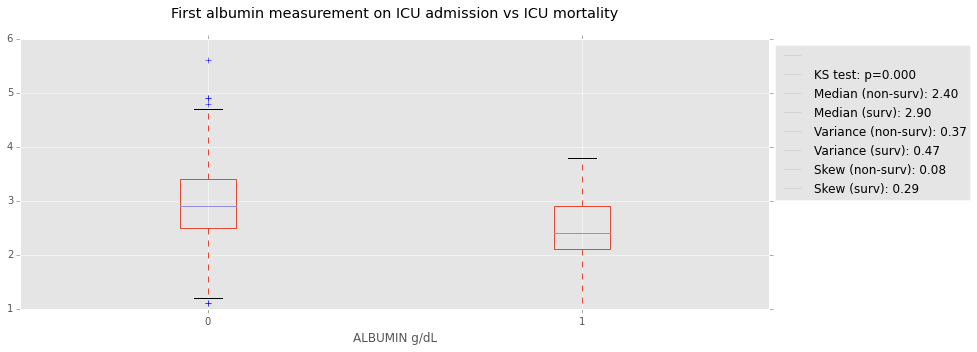

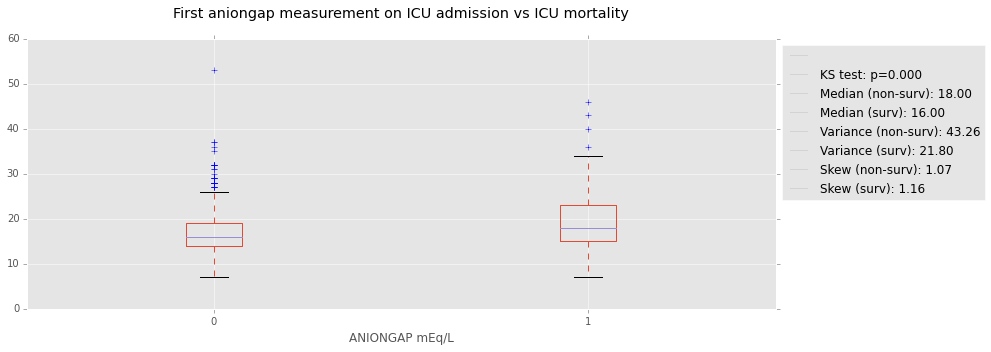

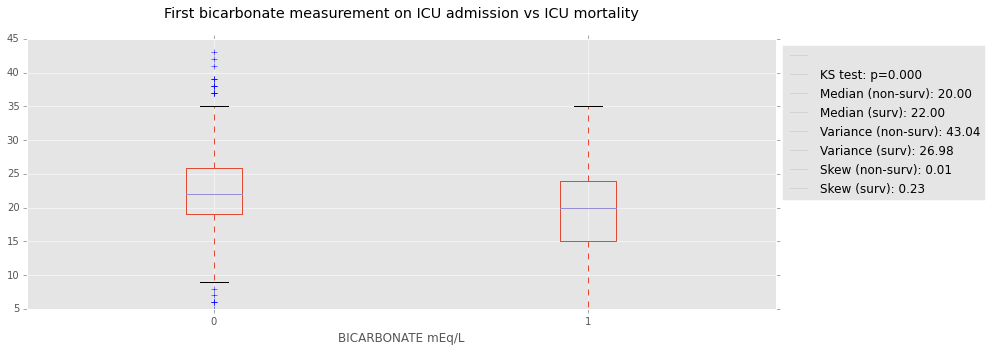

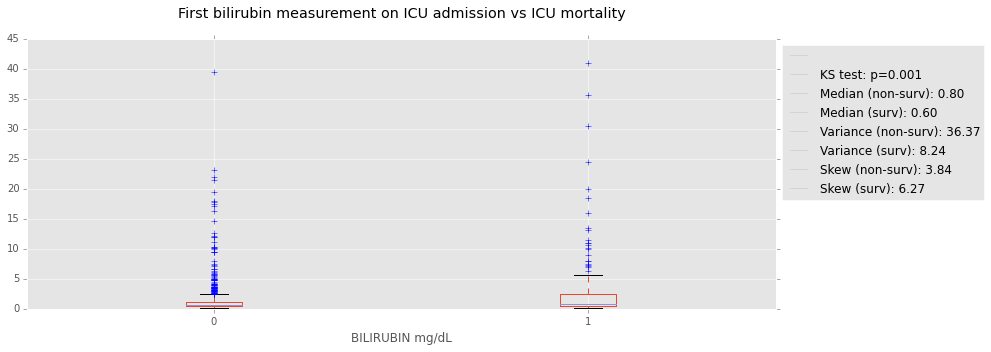

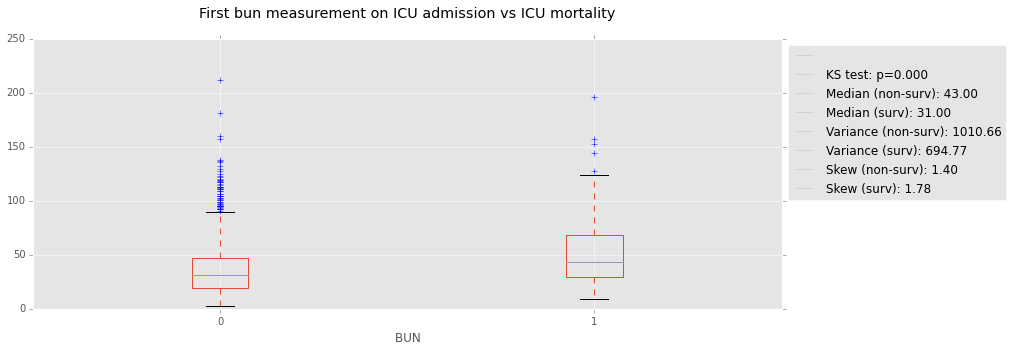

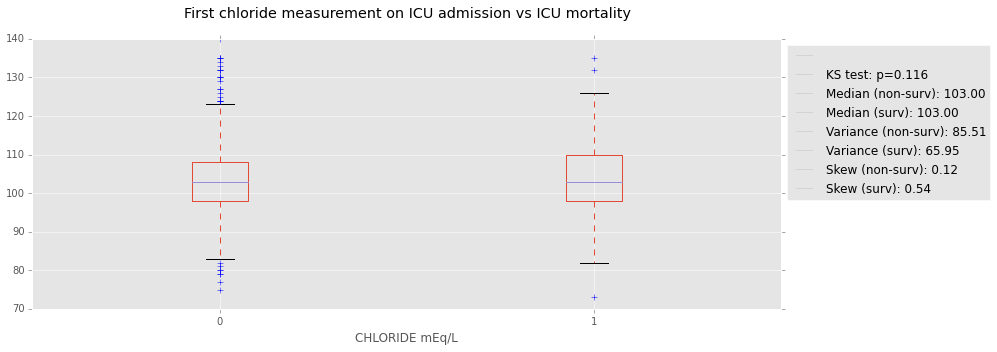

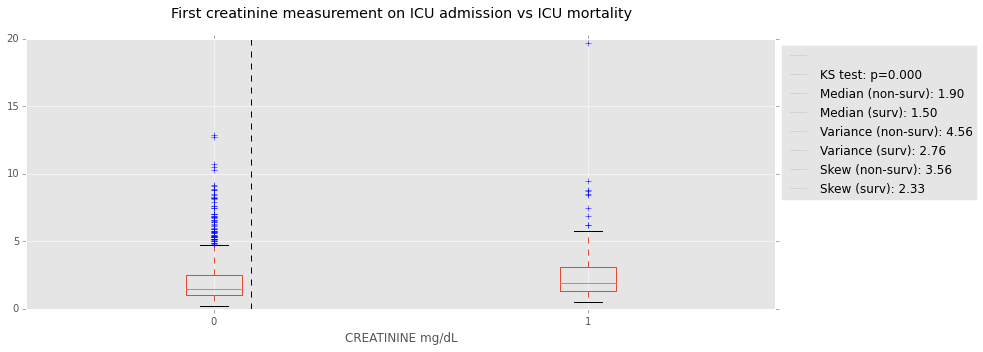

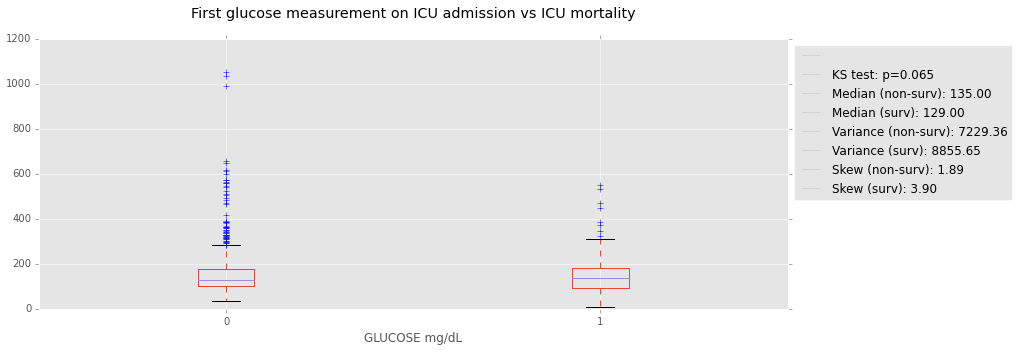

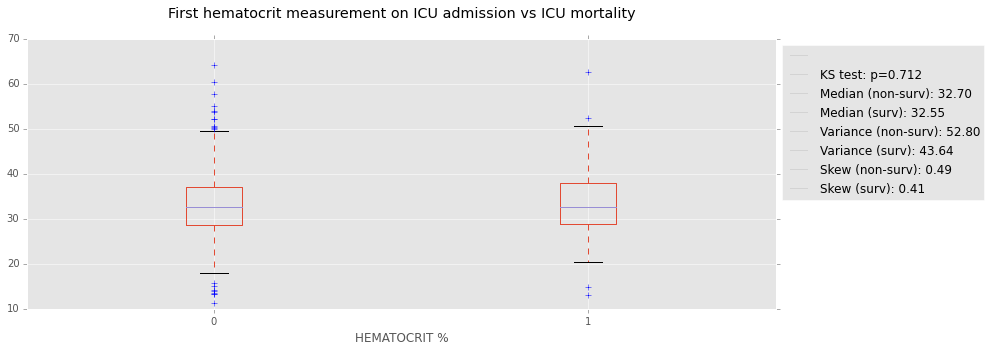

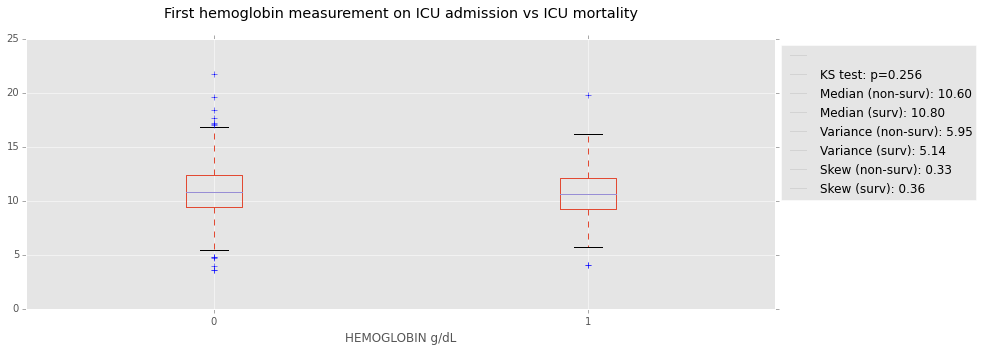

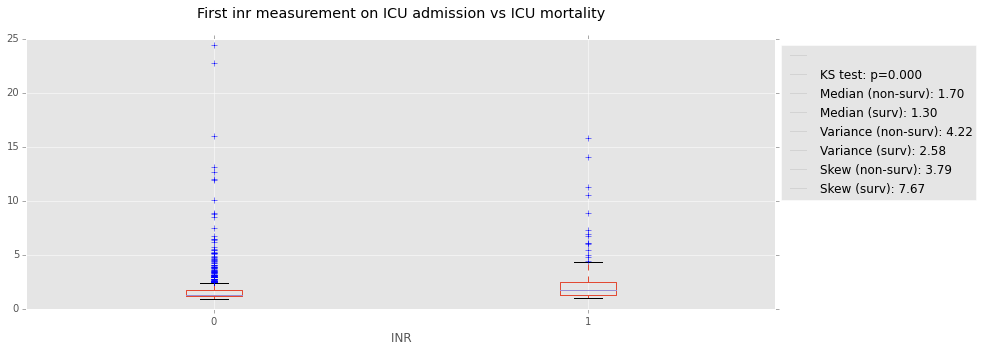

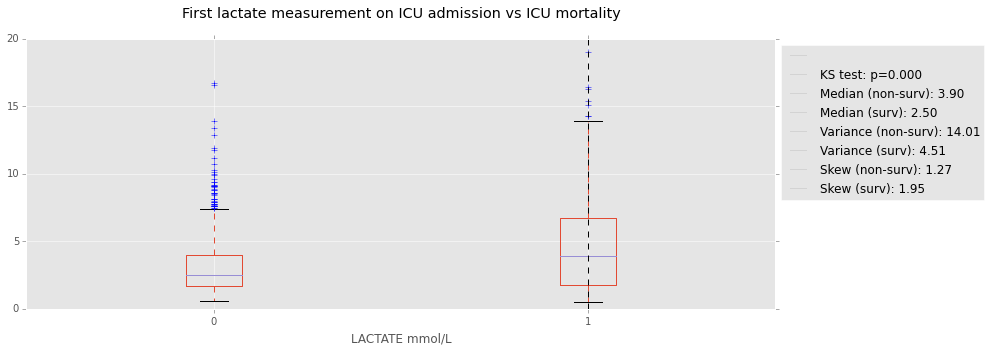

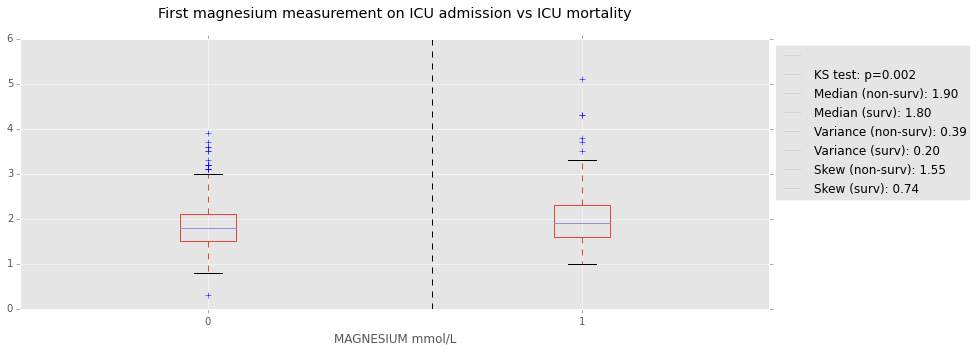

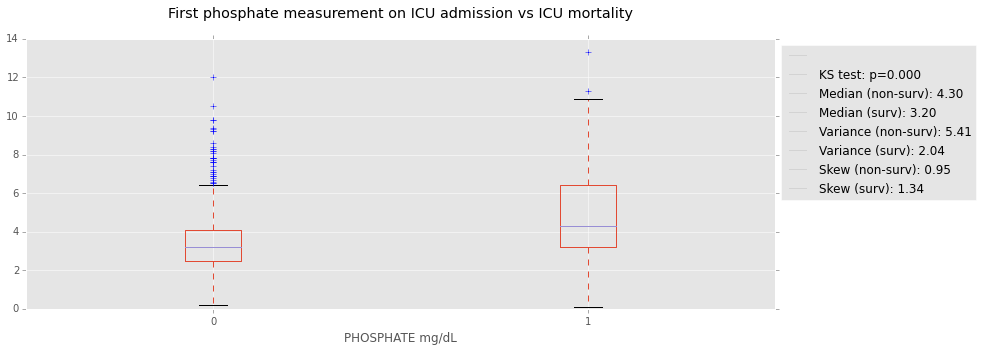

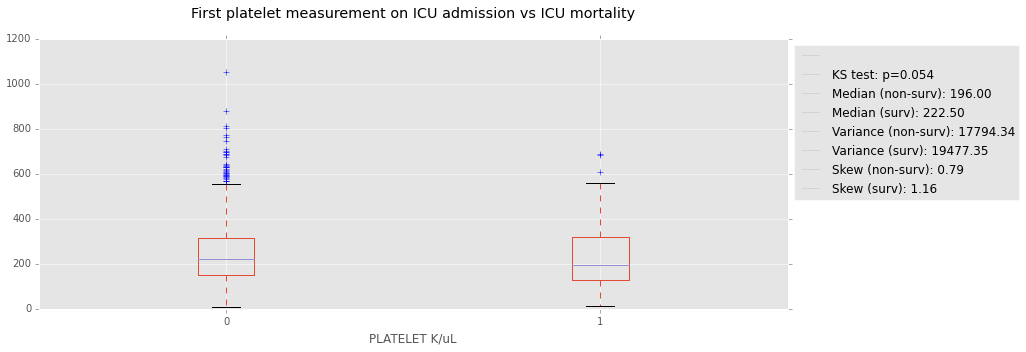

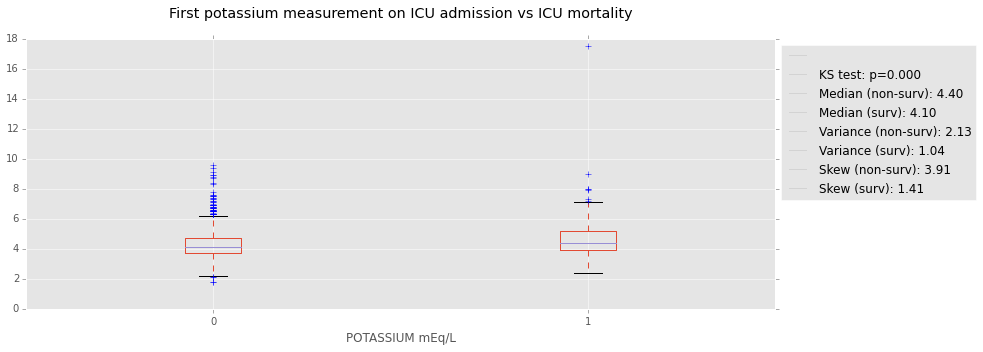

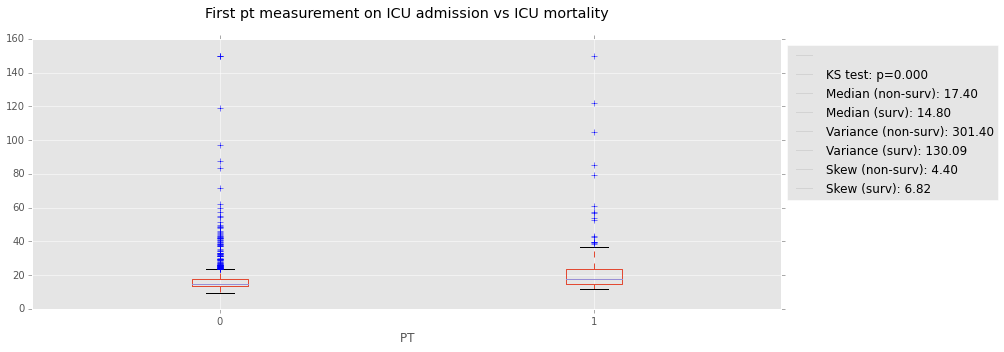

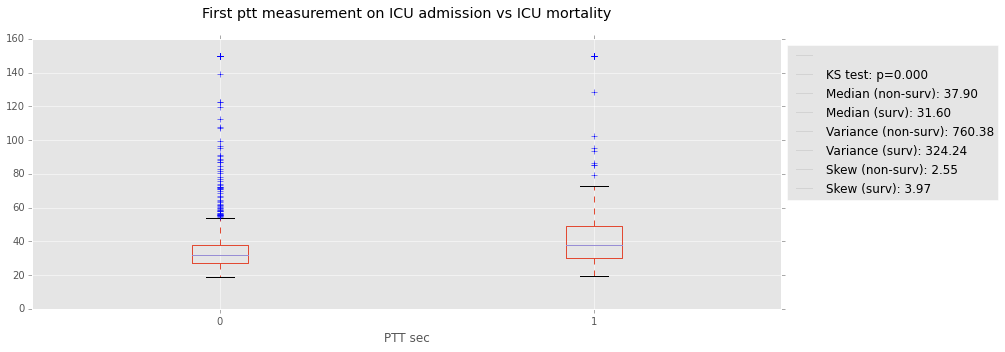

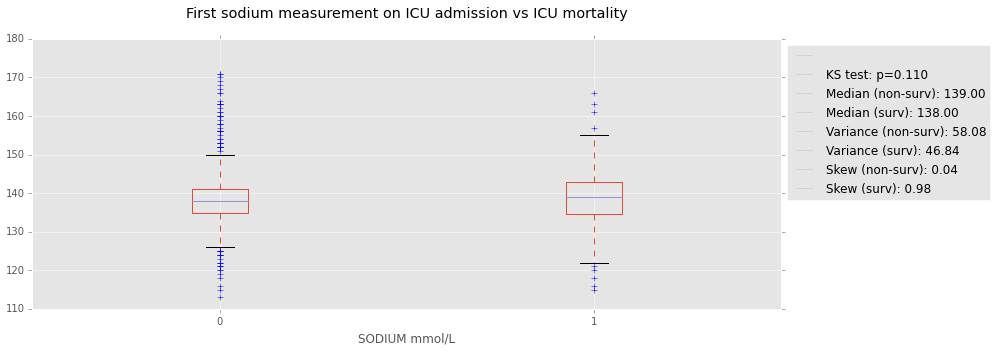

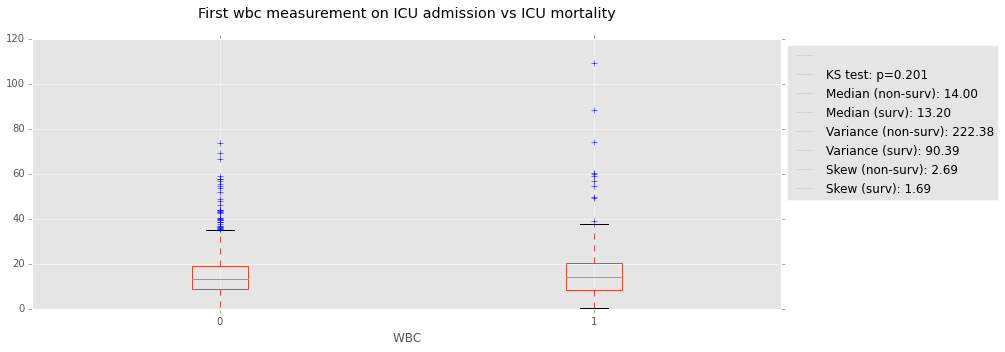

In [13]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    #fig, ax1 = plt.subplots(figsize=(13, 6))
    #fig.canvas.set_window_title('A Boxplot Example')
    #plt.subplots(figsize=(13,6))
    #box_data = data[['mort_icu', l.lower()+'_1st']].dropna()
    data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
   #data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #    label='Non-survival (n={})'.format(n_nonsurv))
    plt.suptitle("")
    '''
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.box(
        label='Survival (n={})'.format(n_surv))
    '''
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    
   # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data[l.lower()+'_1st'].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    

## From the density plots above, a list of variables was generated for which the distribution was very similar between survival and non-survival groups. (Maybe include similarity threshold??)

In [47]:
# Generate list of variables which, from density plots above, are similar between surivial and non-survival groups
cols_list = list(data.columns)
remove_list = ['chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'platelet_1st']
for element in remove_list:
    cols_list.remove(element)
    
display(cols_list)

['mort_icu',
 'aniongap_1st',
 'albumin_1st',
 'bicarbonate_1st',
 'bilirubin_1st',
 'creatinine_1st',
 'lactate_1st',
 'magnesium_1st',
 'phosphate_1st',
 'potassium_1st',
 'ptt_1st',
 'inr_1st',
 'pt_1st',
 'sodium_1st',
 'bun_1st',
 'wbc_1st']

In [48]:
# data4 includes all variables except those identified as similar between survival and non-survival groups. 
data2 = data[cols_list]
data2.head()

,mort_icu,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,lactate_1st,magnesium_1st,phosphate_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,1,19.0,2.1,23.0,0.3,4.2,1.6,1.5,4.4,3.8,31.7,1.7,18.1,137.0,49.0,30.5
1,0,13.0,NaN,23.0,1.4,0.6,1.6,1.4,2.1,2.5,31.0,1.0,12.0,132.0,8.0,6.0
2,0,22.0,NaN,20.0,0.6,0.8,5.0,2.3,4.4,4.9,30.1,1.2,13.3,135.0,15.0,52.0
3,1,19.0,NaN,24.0,NaN,0.8,3.4,NaN,NaN,3.7,22.8,1.2,13.5,142.0,20.0,16.5
4,0,14.0,2.9,17.0,1.8,2.4,4.8,1.0,3.3,5.0,32.7,1.2,13.7,133.0,31.0,16.7


## Removing data points that include any NaN values

In [57]:
# remove samples which have any values that are nan
data2 = data2.dropna()
data2.set_index(np.arange(data2.shape[0]), inplace = True)
data2.head()

,mort_icu,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,lactate_1st,magnesium_1st,phosphate_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,1,19.0,2.1,23.0,0.3,4.2,1.6,1.5,4.4,3.8,31.7,1.7,18.1,137.0,49.0,30.5
1,0,14.0,2.9,17.0,1.8,2.4,4.8,1.0,3.3,5.0,32.7,1.2,13.7,133.0,31.0,16.7
2,0,22.0,2.6,30.0,0.3,7.6,4.3,2.0,3.0,5.1,24.9,1.3,14.2,138.0,66.0,13.1
3,0,17.0,2.9,20.0,0.2,1.9,1.5,2.3,2.6,3.1,29.8,1.4,15.9,166.0,77.0,5.0
4,0,18.0,3.7,27.0,0.8,1.5,4.6,1.7,2.3,5.3,28.6,1.2,13.4,143.0,17.0,30.6


## The survival rate calculated below indicates that 82% of patients survived. 

In [58]:
dead = data2['mort_icu'][data2.mort_icu==1].count()
survivors = data2['mort_icu'][data2.mort_icu==0].count()
survival_rate = float(survivors)/(dead+survivors)
print "Number of  patients deceased = {}".format(dead)
print "Number of patients           = {}".format(dead + survivors)
print "Survival Rate                = {}".format(survival_rate * 100)

Number of  patients deceased = 123
Number of patients           = 688
Survival Rate                = 82.1220930233


## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.30, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, data2[data2.columns[1:]], data2['mort_icu'], cv=5)
display(scores)  


array([ 0.81884058,  0.81884058,  0.81884058,  0.82481752,  0.82481752])

In [60]:
clf_SVC.score(X_test, y_test)
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

array([[165,   0],
       [ 42,   0]])

## The Confusion Matrix indicates that the classifier simply predicts survival for each patient which, because 82% of the patients survived, results in 82% Accuracy. 

## Gaussian Naive Bayes Classification on un-processed data with variables selected based on visual inspection

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.40, random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



0.778985507246


array([[194,  28],
       [ 33,  21]])

## The Confusion Matrix indicates that the classifier predicts survival rates with ~78% accuracy with a mixture of predictions rather than predicting all survival as was the case for the SVM classifier. Unfortunately, the accuracy is not better than predicting all survivors. 

## Multi-Layer Perceptron Classification on un-processed data with variables selected based on visual inspection

In [56]:

X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.20, random_state = 42)

clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(7, 4), random_state=1)

clf_MLP.fit(X_train, y_train)                         

display(clf_MLP.score(X_test, y_test))
y_predsMLP = clf_MLP.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)




0.83333333333333337

array([[106,   5],
       [ 18,   9]])

## Creating a Dataframe of skewness measurements for the raw data and for different transforms to calculate what transform does the best job of normalizing the data

In [71]:
# create dict from which we'll build skew measures dataframe
skew_dict2 = {data2.columns[1]:
              {
             'raw_skew': scats.skew(data2[data2.columns[1]]), 
             'sqrt_skew': scats.skew(np.sqrt(data2[data2.columns[1]])), 
             'log_skew': scats.skew(np.log(data2[data2.columns[1]].add(1))),  
             'boxcox_skew': scats.skew(scats.boxcox(data2[data2.columns[1]].add(1))[0])
             }
             }

print skew_dict2
skew_df = pd.DataFrame.from_dict(skew_dict2, orient = 'index')  
skew_df

{'aniongap_1st': {'sqrt_skew': 0.7103681897218784, 'raw_skew': 1.3916411570405627, 'boxcox_skew': -0.009149579526497292, 'log_skew': 0.19571148665234672}}


,sqrt_skew,raw_skew,boxcox_skew,log_skew
aniongap_1st,0.710368,1.391641,-0.00915,0.195711


In [72]:
# re-order columns
skew_df = skew_df[['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew']]


In [73]:
skew_df

,raw_skew,sqrt_skew,log_skew,boxcox_skew
aniongap_1st,1.391641,0.710368,0.195711,-0.00915


In [74]:
              
for col in data2.columns[2:]:
    raw_skew = scats.skew(data2[col])
    
    sqrt_skew = scats.skew(np.sqrt(data2[col]))
    log_skew = scats.skew(np.log(data2[col].add(1)))
        #print "{} logskew = {}".format(col, new_skew_val2)
    boxcox_skew = scats.skew(scats.boxcox(data2[col].add(1))[0])
    new_row = pd.Series([raw_skew, sqrt_skew, log_skew, boxcox_skew],
                        #index=['measurement', 'raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                        index=['raw_skew', 'sqrt_skew', 'log_skew', 'boxcox_skew'],
                       name = col)

    skew_df = skew_df.append(new_row)#, ignore_index = True)

skew_df

,raw_skew,sqrt_skew,log_skew,boxcox_skew
aniongap_1st,1.391641,0.710368,0.195711,-0.009150
albumin_1st,0.309465,-0.081985,-0.261086,0.002168
bicarbonate_1st,0.125783,-0.459457,-1.085026,0.045017
bilirubin_1st,5.321222,2.730855,1.995406,0.383802
creatinine_1st,2.226479,1.139954,0.779912,0.044181
lactate_1st,1.923699,0.980134,0.535751,0.056559
magnesium_1st,1.239286,0.547915,0.365669,-0.032508
phosphate_1st,1.417862,0.544697,0.090971,-0.006450
potassium_1st,2.792471,1.369657,0.787086,-0.047614
ptt_1st,3.824561,2.695014,1.727757,0.032065


In [75]:
skew_df.columns.name = 'Skewness Values'
skew_df.index.name = 'Lab Measures'

## The figure below shows the skewness values for each lab measurement for normalized data that has been transformed by taking the log, the square root and using the box-cox function. It can be seen that the box-cox function performed better than other transforms in reducing skewness. 


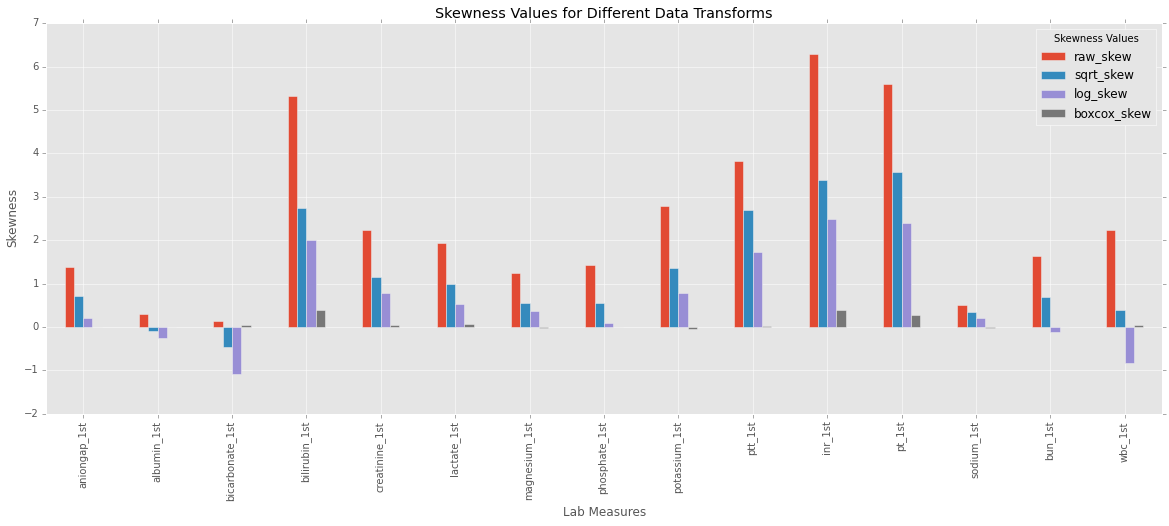

In [76]:
ax = skew_df.plot.bar(figsize = (20,7), title = 'Skewness Values for Different Data Transforms')
ax.set_ylabel("Skewness")

In [78]:
#sqrt_norm_data = np.sqrt(data2_norm[data2_norm.columns[1:]])
#log_norm_data = np.log(data2_norm[data2_norm.columns[1:]].add(1))
boxcox_data = data2.copy()
for feature_name in data2.columns[1:]:
    boxcox_data[feature_name] = scats.boxcox(data2[feature_name].add(1))[0]

boxcox_data.head()

,mort_icu,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,lactate_1st,magnesium_1st,phosphate_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,1,2.247600,1.476279,19.227046,0.218022,0.988622,0.769646,0.739529,1.594248,0.841982,0.740087,0.335366,0.442982,1.303717,4.482837,6.244416
1,0,2.085862,1.879276,14.495187,0.533074,0.828976,1.196027,0.588514,1.389330,0.891524,0.740365,0.318173,0.442520,1.302970,3.909032,4.678755
2,0,2.322848,1.734005,24.632199,0.218022,1.126446,1.155744,0.851327,1.323609,0.894814,0.737518,0.322782,0.442596,1.303898,4.868713,4.135335
3,0,2.189453,1.879276,16.874359,0.160105,0.756218,0.744391,0.905946,1.227290,0.800506,0.739502,0.326690,0.442800,1.308180,5.072199,2.409024
4,0,2.219447,2.238996,22.328812,0.394791,0.680805,1.180550,0.787931,1.147229,0.901097,0.739087,0.318173,0.442471,1.304769,3.194551,6.253836


## Code to identify outliers in normalized data

In [96]:
names_dict = {}
suffix = '_outliers'


for feature in boxcox_data.keys():
    if feature != 'mort_icu':
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(boxcox_data[feature], 25)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(boxcox_data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = boxcox_data[~((boxcox_data[feature] >= Q1 - step) & (boxcox_data[feature] <= Q3 + step))].index
# OPTIONAL: Select the indices for data points you wish to remove

## Code to remove datapoints from normalized data with 3 or more variables that are outliers

In [97]:
all_outliers = []
for feature in names_dict.keys():
    all_outliers.extend(names_dict[feature])
print "the total outlier indices = {}".format(len(all_outliers))
indices, counts = np.unique(all_outliers, return_counts = True)
outlier_dict = {'counts': counts,
                'indices': indices
               }
outlier_df = pd.DataFrame(outlier_dict)

outliers  = list(outlier_df[outlier_df.counts >= 2].indices.values)
print "the following data points have >2 outlying feature and will be removed: \n{}".format(outliers)
# Remove the outliers, if any were specified


boxcox_data2 = boxcox_data.drop(boxcox_data.index[outliers]).reset_index(drop = True)

the total outlier indices = 151
the following data points have >2 outlying feature and will be removed: 
[16, 34, 116, 135, 160, 205, 340, 381, 389, 392, 407, 412, 465, 508, 547, 564, 631, 664, 672]


In [99]:

# I believe this can be done more efficiently with sklearn.preprocessing.scale
boxcox_data_scaled = boxcox_data2.copy()
for feature_name in boxcox_data2.columns[1:]:
#    max_value = data2[feature_name].max()
#    min_value = data2[feature_name].min()
#    data2_norm[feature_name] = (data2[feature_name] - min_value) / (max_value - min_value)
    boxcox_data_scaled[feature_name] = preprocessing.scale(boxcox_data_scaled[feature_name], with_mean = True, 
                                                  with_std = True)
    
display(boxcox_data_scaled.head())
display(boxcox_data.head())


,mort_icu,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,lactate_1st,magnesium_1st,phosphate_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,1,0.425812,-1.107111,0.255702,-0.991934,1.405042,-0.913776,-0.640974,0.590582,-0.514611,-0.105010,0.476790,0.592631,-0.091667,0.596115,1.457442
1,0,-0.723210,0.115440,-0.870013,1.078778,0.575660,0.817741,-2.112161,-0.109405,0.721808,0.013104,-0.786562,-0.710844,-0.709300,-0.135434,0.371456
2,0,0.960389,-0.325261,1.541594,-0.991934,2.121058,0.654153,0.448155,-0.333902,0.803927,-1.199616,-0.447859,-0.498489,0.057879,1.088072,-0.005475
3,0,0.012722,0.115440,-0.304005,-1.372601,0.197672,-1.016334,0.980252,-0.662922,-1.549752,-0.354348,-0.160734,0.077914,3.600075,1.347498,-1.202892
4,0,0.225803,1.206702,0.993615,0.169900,-0.194106,0.754887,-0.169443,-0.936405,0.960739,-0.531264,-0.786562,-0.849958,0.778292,-1.046334,1.463977


,mort_icu,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,lactate_1st,magnesium_1st,phosphate_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,1,2.247600,1.476279,19.227046,0.218022,0.988622,0.769646,0.739529,1.594248,0.841982,0.740087,0.335366,0.442982,1.303717,4.482837,6.244416
1,0,2.085862,1.879276,14.495187,0.533074,0.828976,1.196027,0.588514,1.389330,0.891524,0.740365,0.318173,0.442520,1.302970,3.909032,4.678755
2,0,2.322848,1.734005,24.632199,0.218022,1.126446,1.155744,0.851327,1.323609,0.894814,0.737518,0.322782,0.442596,1.303898,4.868713,4.135335
3,0,2.189453,1.879276,16.874359,0.160105,0.756218,0.744391,0.905946,1.227290,0.800506,0.739502,0.326690,0.442800,1.308180,5.072199,2.409024
4,0,2.219447,2.238996,22.328812,0.394791,0.680805,1.180550,0.787931,1.147229,0.901097,0.739087,0.318173,0.442471,1.304769,3.194551,6.253836


In [86]:
#remove_list

['chloride_1st',
 'glucose_1st',
 'hematocrit_1st',
 'hemoglobin_1st',
 'platelet_1st']

In [87]:
'''
# a dictionary is created containing units of measure for the different lab measurements
labs_dict2 = labs_dict

# could be done more succinctly using the dictionary described above

for item in remove_list:
    del labs_dict2[item]

print labs_dict2
print boxcox_data_scaled.columns

import collections
labs_dict3 = collections.OrderedDict(sorted(labs_dict2.items()))
labs_dict3
'''

{'wbc_1st': '', 'bicarbonate_1st': 'mEq/L', 'phosphate_1st': 'mg/dL', 'lactate_1st': 'mmol/L', 'potassium_1st': 'mEq/L', 'creatinine_1st': 'mg/dL', 'magnesium_1st': 'mmol/L', 'aniongap_1st': 'mEq/L', 'pt_1st': '', 'ptt_1st': 'sec', 'albumin_1st': 'g/dL', 'bun_1st': '', 'inr_1st': '', 'bilirubin_1st': 'mg/dL', 'sodium_1st': 'mmol/L'}
Index([u'mort_icu', u'aniongap_1st', u'albumin_1st', u'bicarbonate_1st',
       u'bilirubin_1st', u'creatinine_1st', u'lactate_1st', u'magnesium_1st',
       u'phosphate_1st', u'potassium_1st', u'ptt_1st', u'inr_1st', u'pt_1st',
       u'sodium_1st', u'bun_1st', u'wbc_1st'],
      dtype='object')


## Plotting frequency distribution for each lab measurement for both survival and non-survival groups. 

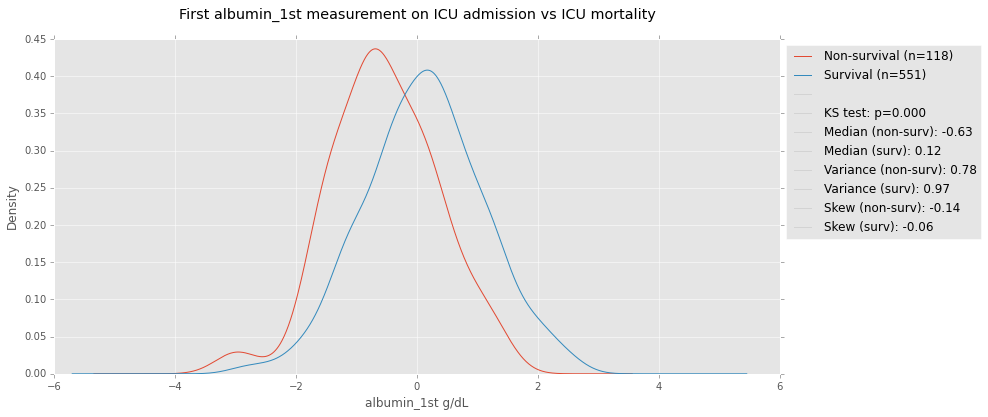

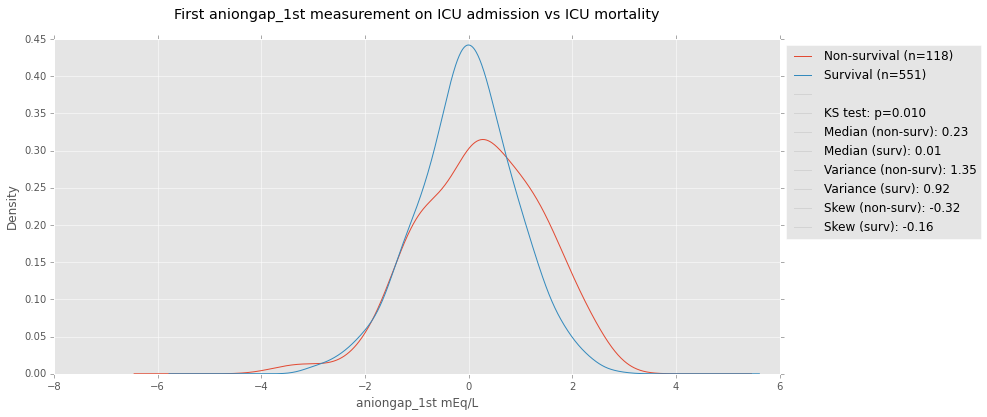

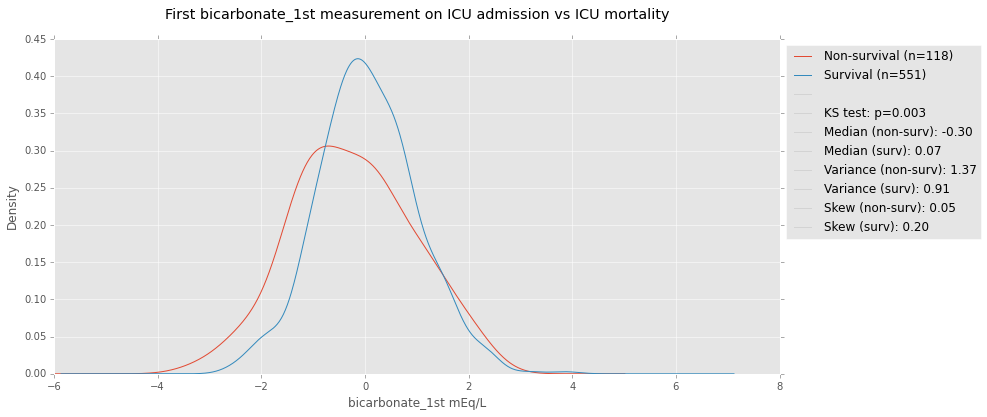

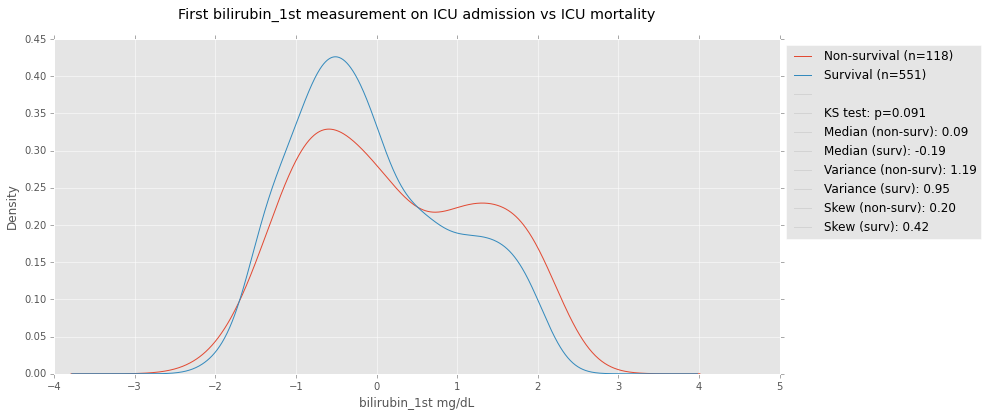

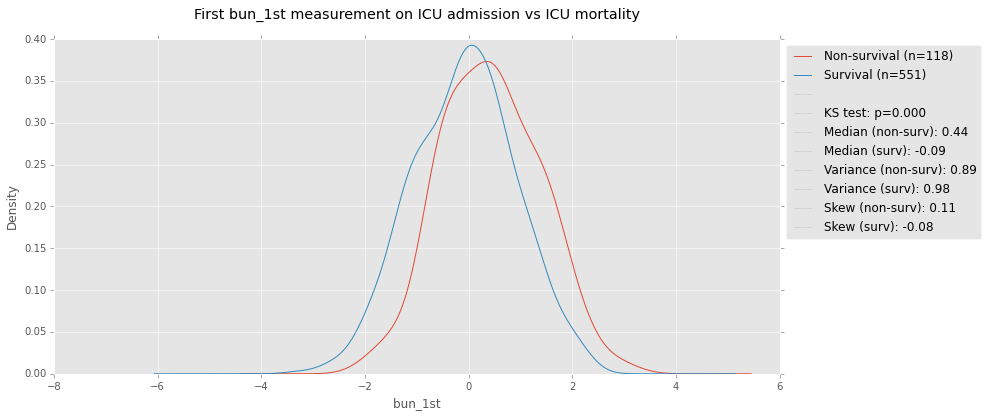

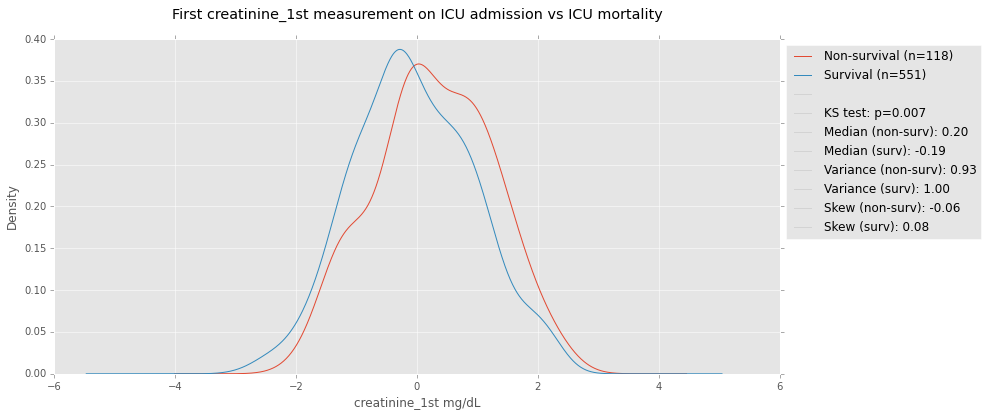

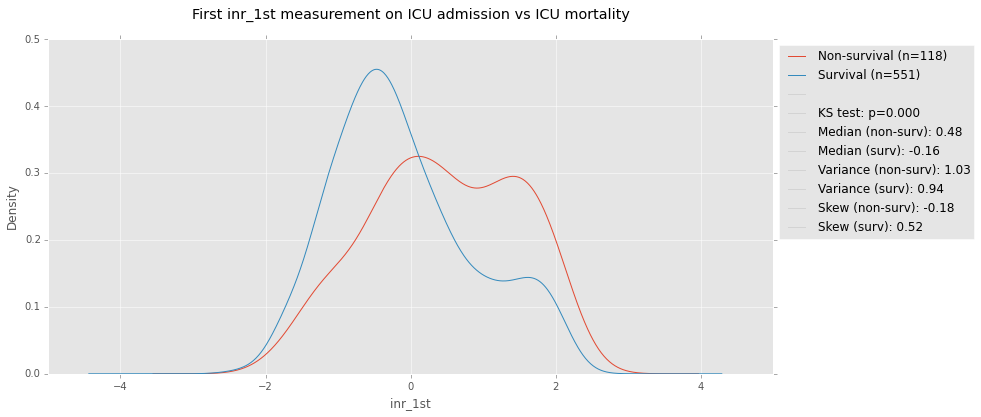

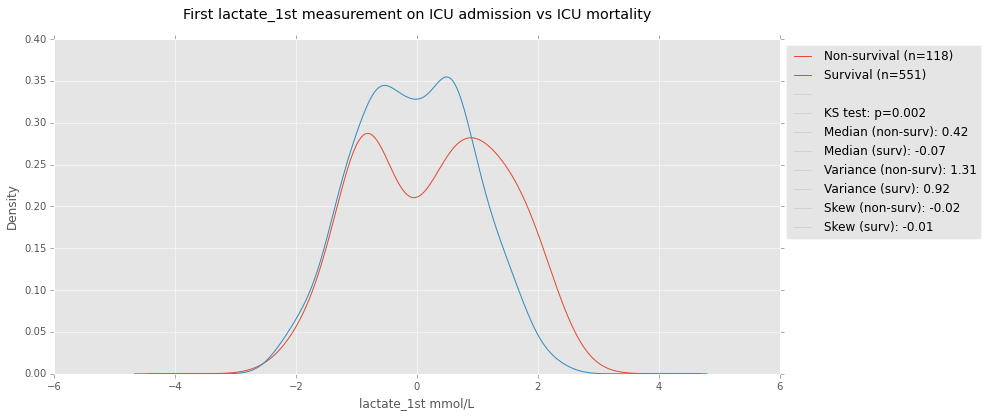

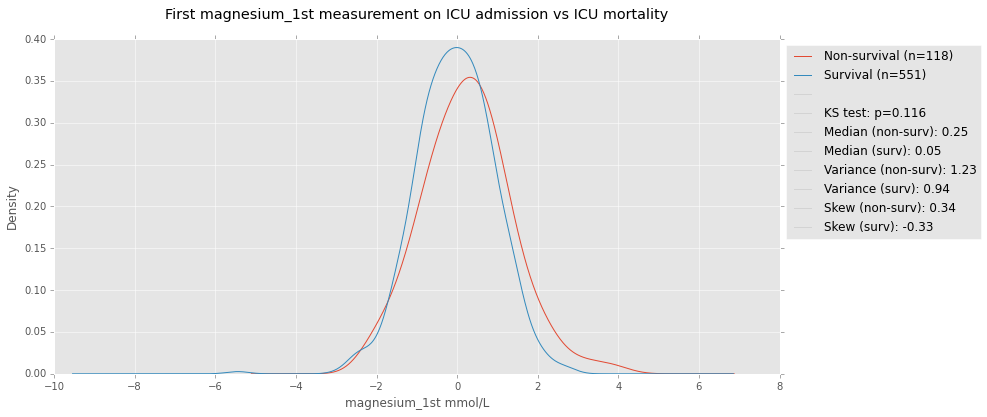

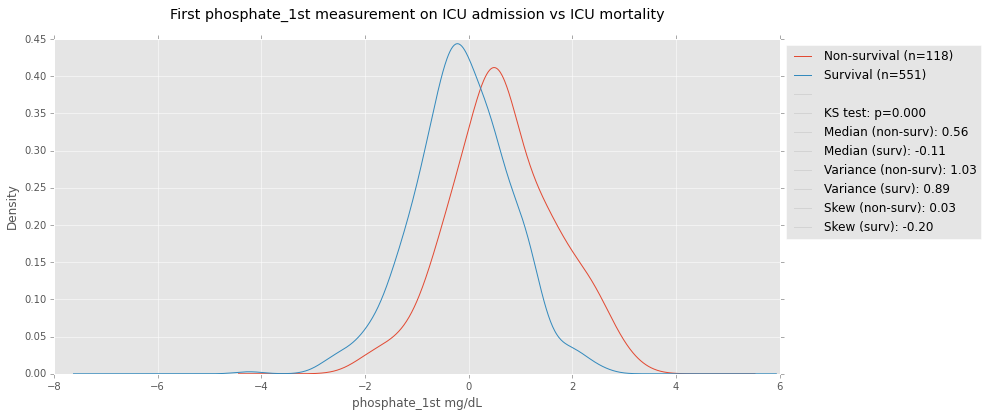

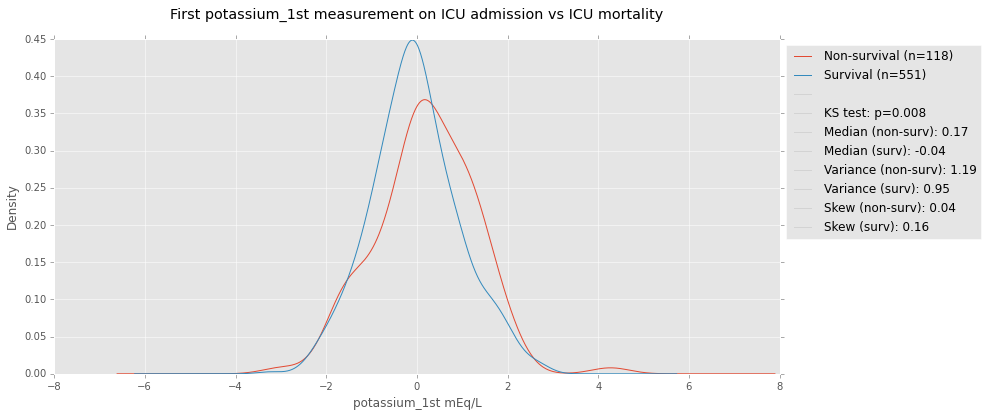

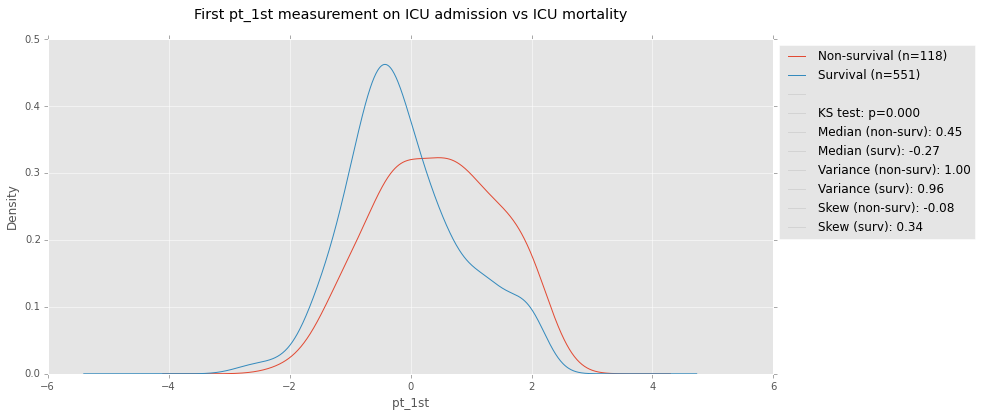

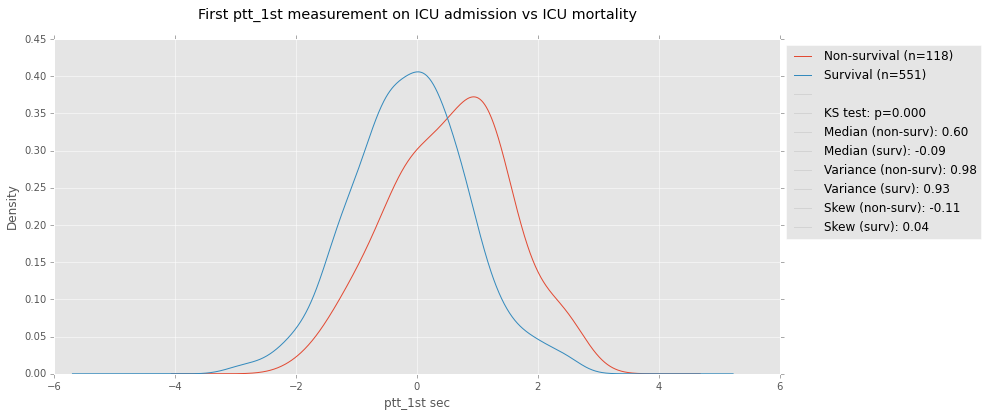

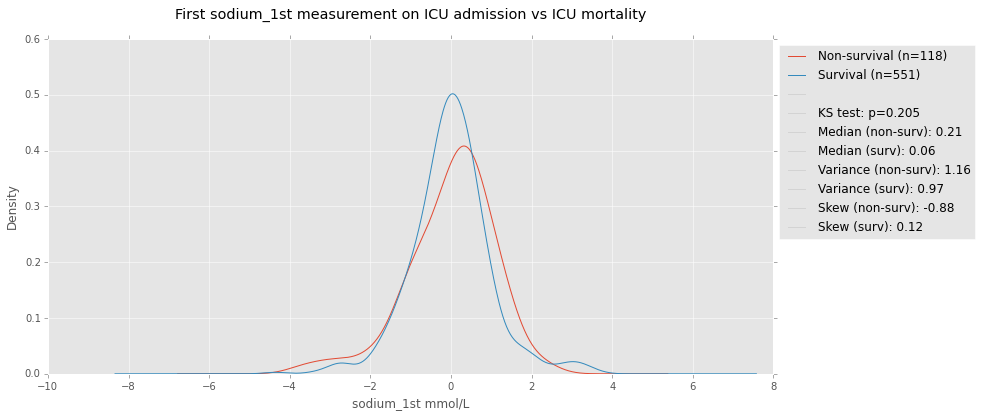

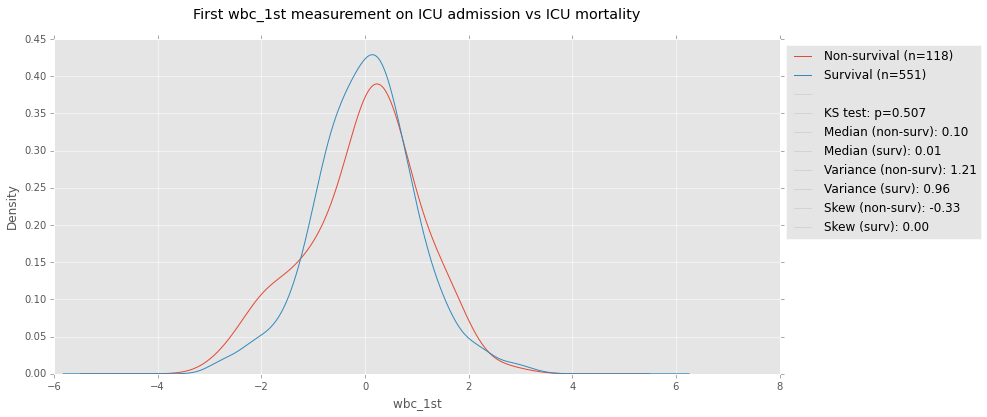

In [100]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().count()
    n_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().median()
    med_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().median()
    var_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().var()
    var_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().var()
    skew_nonsurv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().skew()
    skew_surv = boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna(),
                              boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    boxcox_data_scaled[l][boxcox_data_scaled.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    #plt.xlim(0, boxcox_data_scaled[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

## Performing PCA on box-cox transformed, scaled data with outliers removed

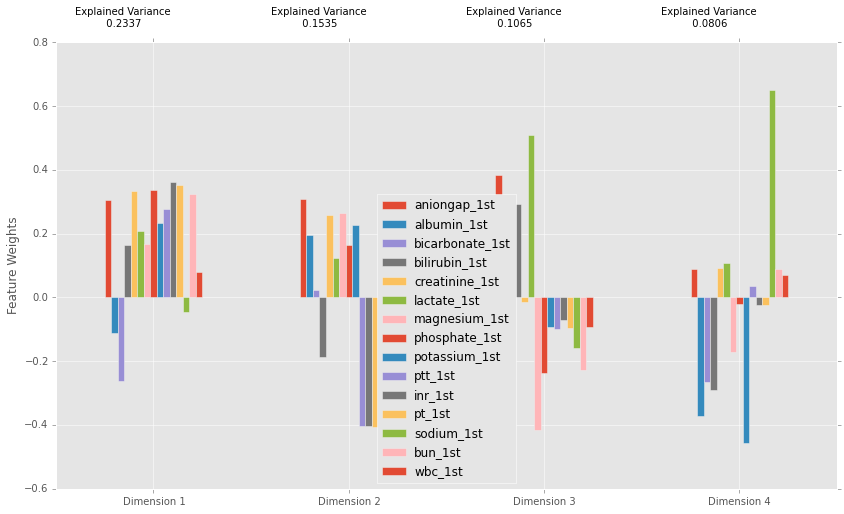

In [135]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 4).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [137]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4
0,0.944557,0.073315,-1.099270,1.104303
1,-0.200864,-0.068556,1.835088,-0.429613
2,0.445015,2.522434,-0.447036,0.031549
3,-0.673605,0.881345,-1.628588,3.272869
4,-1.315561,1.147786,0.819869,-0.531504


## Scatterplot of Box-Cox transformed data with outliers removed. 

/Users/robertbeetel/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


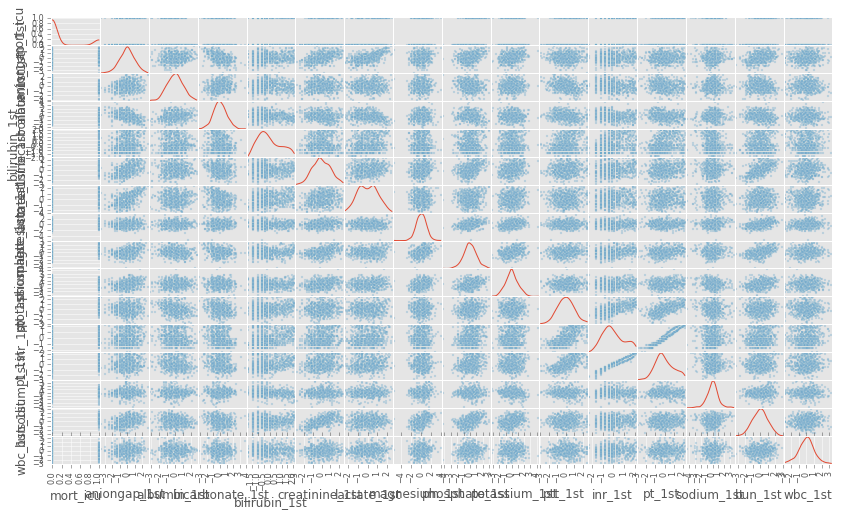

In [102]:
pd.scatter_matrix(boxcox_data_scaled[1:], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [138]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(reduced_data, 
                                                    boxcox_data_scaled['mort_icu'], test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


0.825870646766


array([[158,   6],
       [ 29,   8]])

## Box-Cox transformed data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [139]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                                                    boxcox_data_scaled['mort_icu'], test_size = 0.40, random_state = 42)


clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



0.82089552238805974

array([[220,   0],
       [ 48,   0]])

In [ ]:
data[data.columns[5:]].head()

## Neural Network Classifier was trained and tested using principle components of normalized data .

In [166]:
boxcox_dead = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 1]
boxcox_survivors = boxcox_data_scaled[boxcox_data_scaled.mort_icu == 0]
display(boxcox_dead.shape[0])
display(boxcox_survivors.shape[0])
boxcox_survivors_reduced = boxcox_survivors.sample(boxcox_dead.shape[0])
frames = [boxcox_survivors_reduced, boxcox_dead]
boxcox_even = pd.concat(frames)
boxcox_even.shape

118

551

(236, 16)

In [171]:
num_samps = boxcox_even.shape[0]
display(num_samps)

boxcox_even2 = boxcox_even.sample(n=num_samps)
#boxcox_even2.shape()
boxcox_even2.shape

236

(236, 16)

In [173]:
boxcox_even2.head(10)

,mort_icu,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,lactate_1st,magnesium_1st,phosphate_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
74,0,-0.459600,-0.325261,-0.870013,1.819611,0.436425,-1.125107,0.448155,0.165210,-1.221417,-0.044913,0.084350,0.133793,-1.194087,0.421398,2.225092
551,0,0.225803,-0.325261,-0.680580,-0.991934,0.816570,0.198552,0.448155,0.098963,-0.514611,0.772821,1.958234,2.025139,0.057879,2.155407,-0.269571
529,1,0.012722,-0.029324,-0.680580,0.314963,0.197672,0.338915,-0.398471,0.355277,0.883533,-0.515881,-0.447859,-0.666497,0.495448,0.009678,0.707512
234,1,0.425812,-0.325261,0.069776,-0.412808,-0.309021,0.382682,0.634001,0.590582,-0.153861,-0.411507,-1.189129,-1.158385,1.189916,0.844373,1.522159
642,1,0.614147,-1.609914,-1.636543,1.357888,-0.309021,1.226636,-0.398471,0.293306,0.549525,1.289792,1.253325,1.411390,-0.243118,0.528272,0.200731
159,1,-1.320116,-1.439165,0.255702,0.169900,-1.419154,-0.638001,-0.398471,-0.257129,-1.067881,-0.044913,0.294880,0.337416,0.351400,-0.662624,0.158771
172,1,-0.723210,-1.439165,-0.870013,0.169900,-0.708137,-0.555227,-1.464222,-1.819803,-1.381877,2.498286,0.476790,0.553723,0.917153,-0.037359,-2.743686
148,0,-1.008842,1.206702,1.723314,0.442407,-0.432294,-0.638001,0.252871,0.165210,-0.269548,-1.036682,-1.189129,-1.450865,0.917153,-0.530632,0.292582
86,1,-1.661593,-1.609914,1.359415,-1.840038,-0.708137,-1.240757,-0.898333,0.031160,-0.269548,-1.220815,-1.671560,-1.513736,0.495448,-0.595346,-0.219204
446,1,-0.215086,-1.609914,-1.251402,0.003588,0.701751,-0.476413,0.980252,0.293306,-0.042399,1.264981,0.294880,0.450350,0.778292,1.390966,1.118181


In [189]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.40, 
                                                    random_state = 42)

### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


0.526315789474


array([[24, 23],
       [22, 26]])

## Support Vector Machine Classification on un-processed data with variables selected based on visual inspection
The variables enumerated in 'remove_list' were observed for both survivors and non-survivors and appeared to be very similar in distribution. Because they appeared to be very similar for both groups, they were excluded as features for classification. 

In [184]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)



clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, boxcox_data_scaled[boxcox_data_scaled.columns[1:]], 
                         boxcox_data_scaled['mort_icu'], cv=5)
display(scores)  
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

array([ 0.84444444,  0.82835821,  0.8358209 ,  0.85714286,  0.84210526])

array([[20, 14],
       [21, 16]])

In [118]:
display(clf_SVC.score(X_test, y_test))
y_predsSVC = clf_SVC.predict(X_test)
display(metrics.confusion_matrix(y_test, y_predsSVC))

0.85074626865671643

array([[109,   0],
       [ 20,   5]])

In [185]:
X_train, X_test, y_train, y_test = train_test_split(boxcox_even2[boxcox_even2.columns[1:]], 
                                                    boxcox_even['mort_icu'], test_size = 0.30, 
                                                    random_state = 42)

clf = MLPClassifier(solver='sgd', alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)                         

display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_predsMLP)



0.50704225352112675

array([[16, 18],
       [17, 20]])

In [ ]:
print "monkey"

In [201]:
diagnoses_codes = pd.DataFrame.from_csv('IDC9_DEADLY_DIAGNOSES.csv')
diagnoses_codes.head()

,diagnosis,icd9_code,short_title
icustay_id,,,
280836,DYSPNEA,48241,Meth sus pneum d/t Staph
280836,DYSPNEA,4280,CHF NOS
280836,DYSPNEA,51881,Acute respiratry failure
280836,DYSPNEA,5845,"Ac kidny fail, tubr necr"
280836,DYSPNEA,4275,Cardiac arrest


In [202]:
diagnoses_list = diagnoses_codes.icd9_code.unique()
diagnoses_list2 = diagnoses_codes.diagnosis.unique()
display(len(diagnoses_list))
display(len(diagnoses_list2))

3254

2337

In [203]:
unique_codes = diagnoses_codes.drop_duplicates(['icd9_code', 'short_title'])
unique_codes.shape


(3254, 3)

In [204]:
unique_codes.head()

,diagnosis,icd9_code,short_title
icustay_id,,,
280836,DYSPNEA,48241,Meth sus pneum d/t Staph
280836,DYSPNEA,4280,CHF NOS
280836,DYSPNEA,51881,Acute respiratry failure
280836,DYSPNEA,5845,"Ac kidny fail, tubr necr"
280836,DYSPNEA,4275,Cardiac arrest


In [192]:
len(diagnoses_list)

6955

In [197]:
diag_counts = diagnoses_codes.icd9_code.value_counts()

In [198]:
diag_counts[0:10]

51881    2668
4019     2260
42731    2237
4280     2195
5849     2132
99592    1713
0389     1561
2762     1341
25000    1221
486      1154
Name: icd9_code, dtype: int64

In [199]:
diagnoses_list[0:10]

array(['53100', '41071', '2859', '41401', '725', '1915', '3314', '53081',
       '4111', '48283'], dtype=object)

In [205]:
boxcox_data_scaled.columns

Index([u'mort_icu', u'aniongap_1st', u'albumin_1st', u'bicarbonate_1st',
       u'bilirubin_1st', u'creatinine_1st', u'lactate_1st', u'magnesium_1st',
       u'phosphate_1st', u'potassium_1st', u'ptt_1st', u'inr_1st', u'pt_1st',
       u'sodium_1st', u'bun_1st', u'wbc_1st'],
      dtype='object')

In [211]:
boxcox_data_scaled_subset = boxcox_data_scaled[['mort_icu', 'albumin_1st', 'bicarbonate_1st', 'inr_1st', 'phosphate_1st',
                                                'ptt_1st']]
boxcox_data_scaled_subset.head()

,mort_icu,albumin_1st,bicarbonate_1st,inr_1st,phosphate_1st,ptt_1st
0,1,-1.107111,0.255702,0.476790,0.590582,-0.105010
1,0,0.115440,-0.870013,-0.786562,-0.109405,0.013104
2,0,-0.325261,1.541594,-0.447859,-0.333902,-1.199616
3,0,0.115440,-0.304005,-0.160734,-0.662922,-0.354348
4,0,1.206702,0.993615,-0.786562,-0.936405,-0.531264


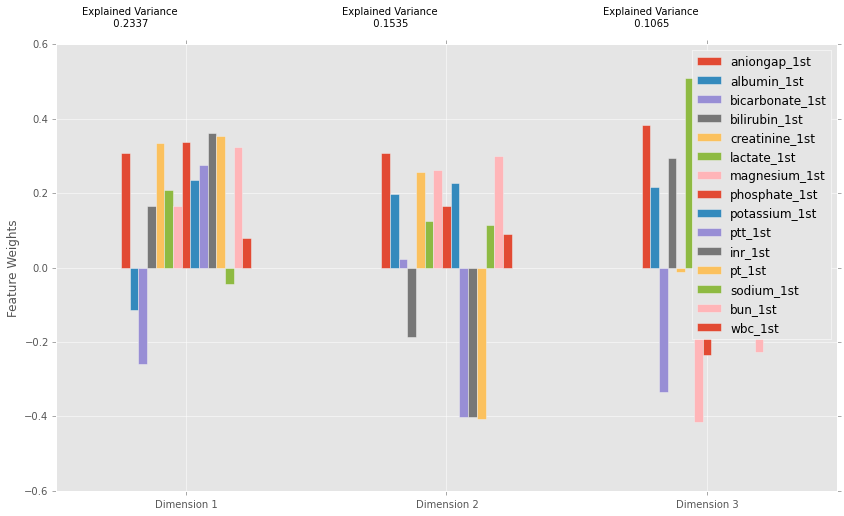

In [210]:
# principle component analysis is used to reduce the dimensionality of data

#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 3).fit(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(boxcox_data_scaled[boxcox_data_scaled.columns[1:]], pca)


In [137]:
reduced_data = pca.transform(boxcox_data_scaled[boxcox_data_scaled.columns[1:]])
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4']) #,
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_data.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4
0,0.944557,0.073315,-1.099270,1.104303
1,-0.200864,-0.068556,1.835088,-0.429613
2,0.445015,2.522434,-0.447036,0.031549
3,-0.673605,0.881345,-1.628588,3.272869
4,-1.315561,1.147786,0.819869,-0.531504


## Scatterplot of Box-Cox transformed data with outliers removed. 

## Normalized data principle components split into training and testing groups. A Gaussian Naive Bayes classifier is trained and tested. 

In [213]:
feat_list = list(boxcox_data_scaled_subset.columns[1:])
feat_list

['albumin_1st', 'bicarbonate_1st', 'inr_1st', 'phosphate_1st', 'ptt_1st']

In [214]:
# Training using 80% of data and testing using 20%. 
X_train, X_test, y_train, y_test = train_test_split(boxcox_data_scaled_subset[feat_list], 
                                                    boxcox_data_scaled_subset['mort_icu'], 
                                                    test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)


0.820895522388


array([[149,  15],
       [ 21,  16]])